In [1]:
from SonicBatt import utils
import os
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1.inset_locator import (InsetPosition, mark_inset)
from matplotlib.ticker import FormatStrFormatter

root_dir = utils.root_dir()
study_path = os.path.join(root_dir, 'studies', 'degradation')
data_path = os.path.join(study_path, 'Raw Data')
visualistion_path = os.path.join(study_path, 'Visualisation')
ancillary_data_path = os.path.join(study_path, 'Ancillary Data')

database = pd.read_excel(os.path.join(data_path, 'database.xlsx'))
degr_tests = database.loc[database['test_type']=='degradation_exp1'].reset_index(drop=True)

cycles_completed = [int(i) for i in degr_tests['cycles_completed'].to_list()]
days_elapsed = degr_tests['days_elapsed'].to_list()
cycles_and_days = []
for i in range(len(cycles_completed)):
    cycles_and_days.append(
        '{} (day {})'.format(int(cycles_completed[i]), int(days_elapsed[i]))
        )

def colorscheme(n_increments, cmap='Blues'):
    return iter(
        mpl.colormaps[cmap](np.linspace(0.2, 1, n_increments))
    )

temp_colorsheme = ListedColormap(cm.Reds(np.linspace(0.2, 1, 256)))

# Plot font settings
ticksize=8
mpl.rc('xtick', labelsize=ticksize)
mpl.rc('ytick', labelsize=ticksize)
mpl.rc('axes', titlesize=12, labelsize=10) # --> labelsize also acts on colorbar label.
mpl.rc('legend', fontsize=8, title_fontsize=10)
mpl.rc('lines', linewidth=0.8, markersize=1)


In [2]:
# Identify Acoustic Peaks
parquet_filename = 'Degradation_exp1_peaks.parquet'
parquet_filepath = os.path.join(ancillary_data_path, parquet_filename)
if not os.path.exists(ancillary_data_path):
    os.makedirs(ancillary_data_path)
if not os.path.exists(parquet_filepath):
    # Find peaks and savethem
    for i in range(len(degr_tests)):
        print('{} out of {}'.format(i, len(degr_tests)))
        test_id = degr_tests['test_id'].iloc[i]
        test_dir = os.path.join(data_path, test_id)
        temp_df = utils.df_with_peaks(data_path, test_id, passes=50)
        temp_df = temp_df[['cycling', 'peak_tofs', 'peak_heights']]
        temp_df[('cycling', 'test_id')] = test_id
        if i == 0:
            df = temp_df
        else:
            df = pd.concat([df, temp_df], axis=0)
    # Save the concatenated file
    df.to_parquet(parquet_filepath)
else:
    df = pq.read_table(parquet_filepath).to_pandas()


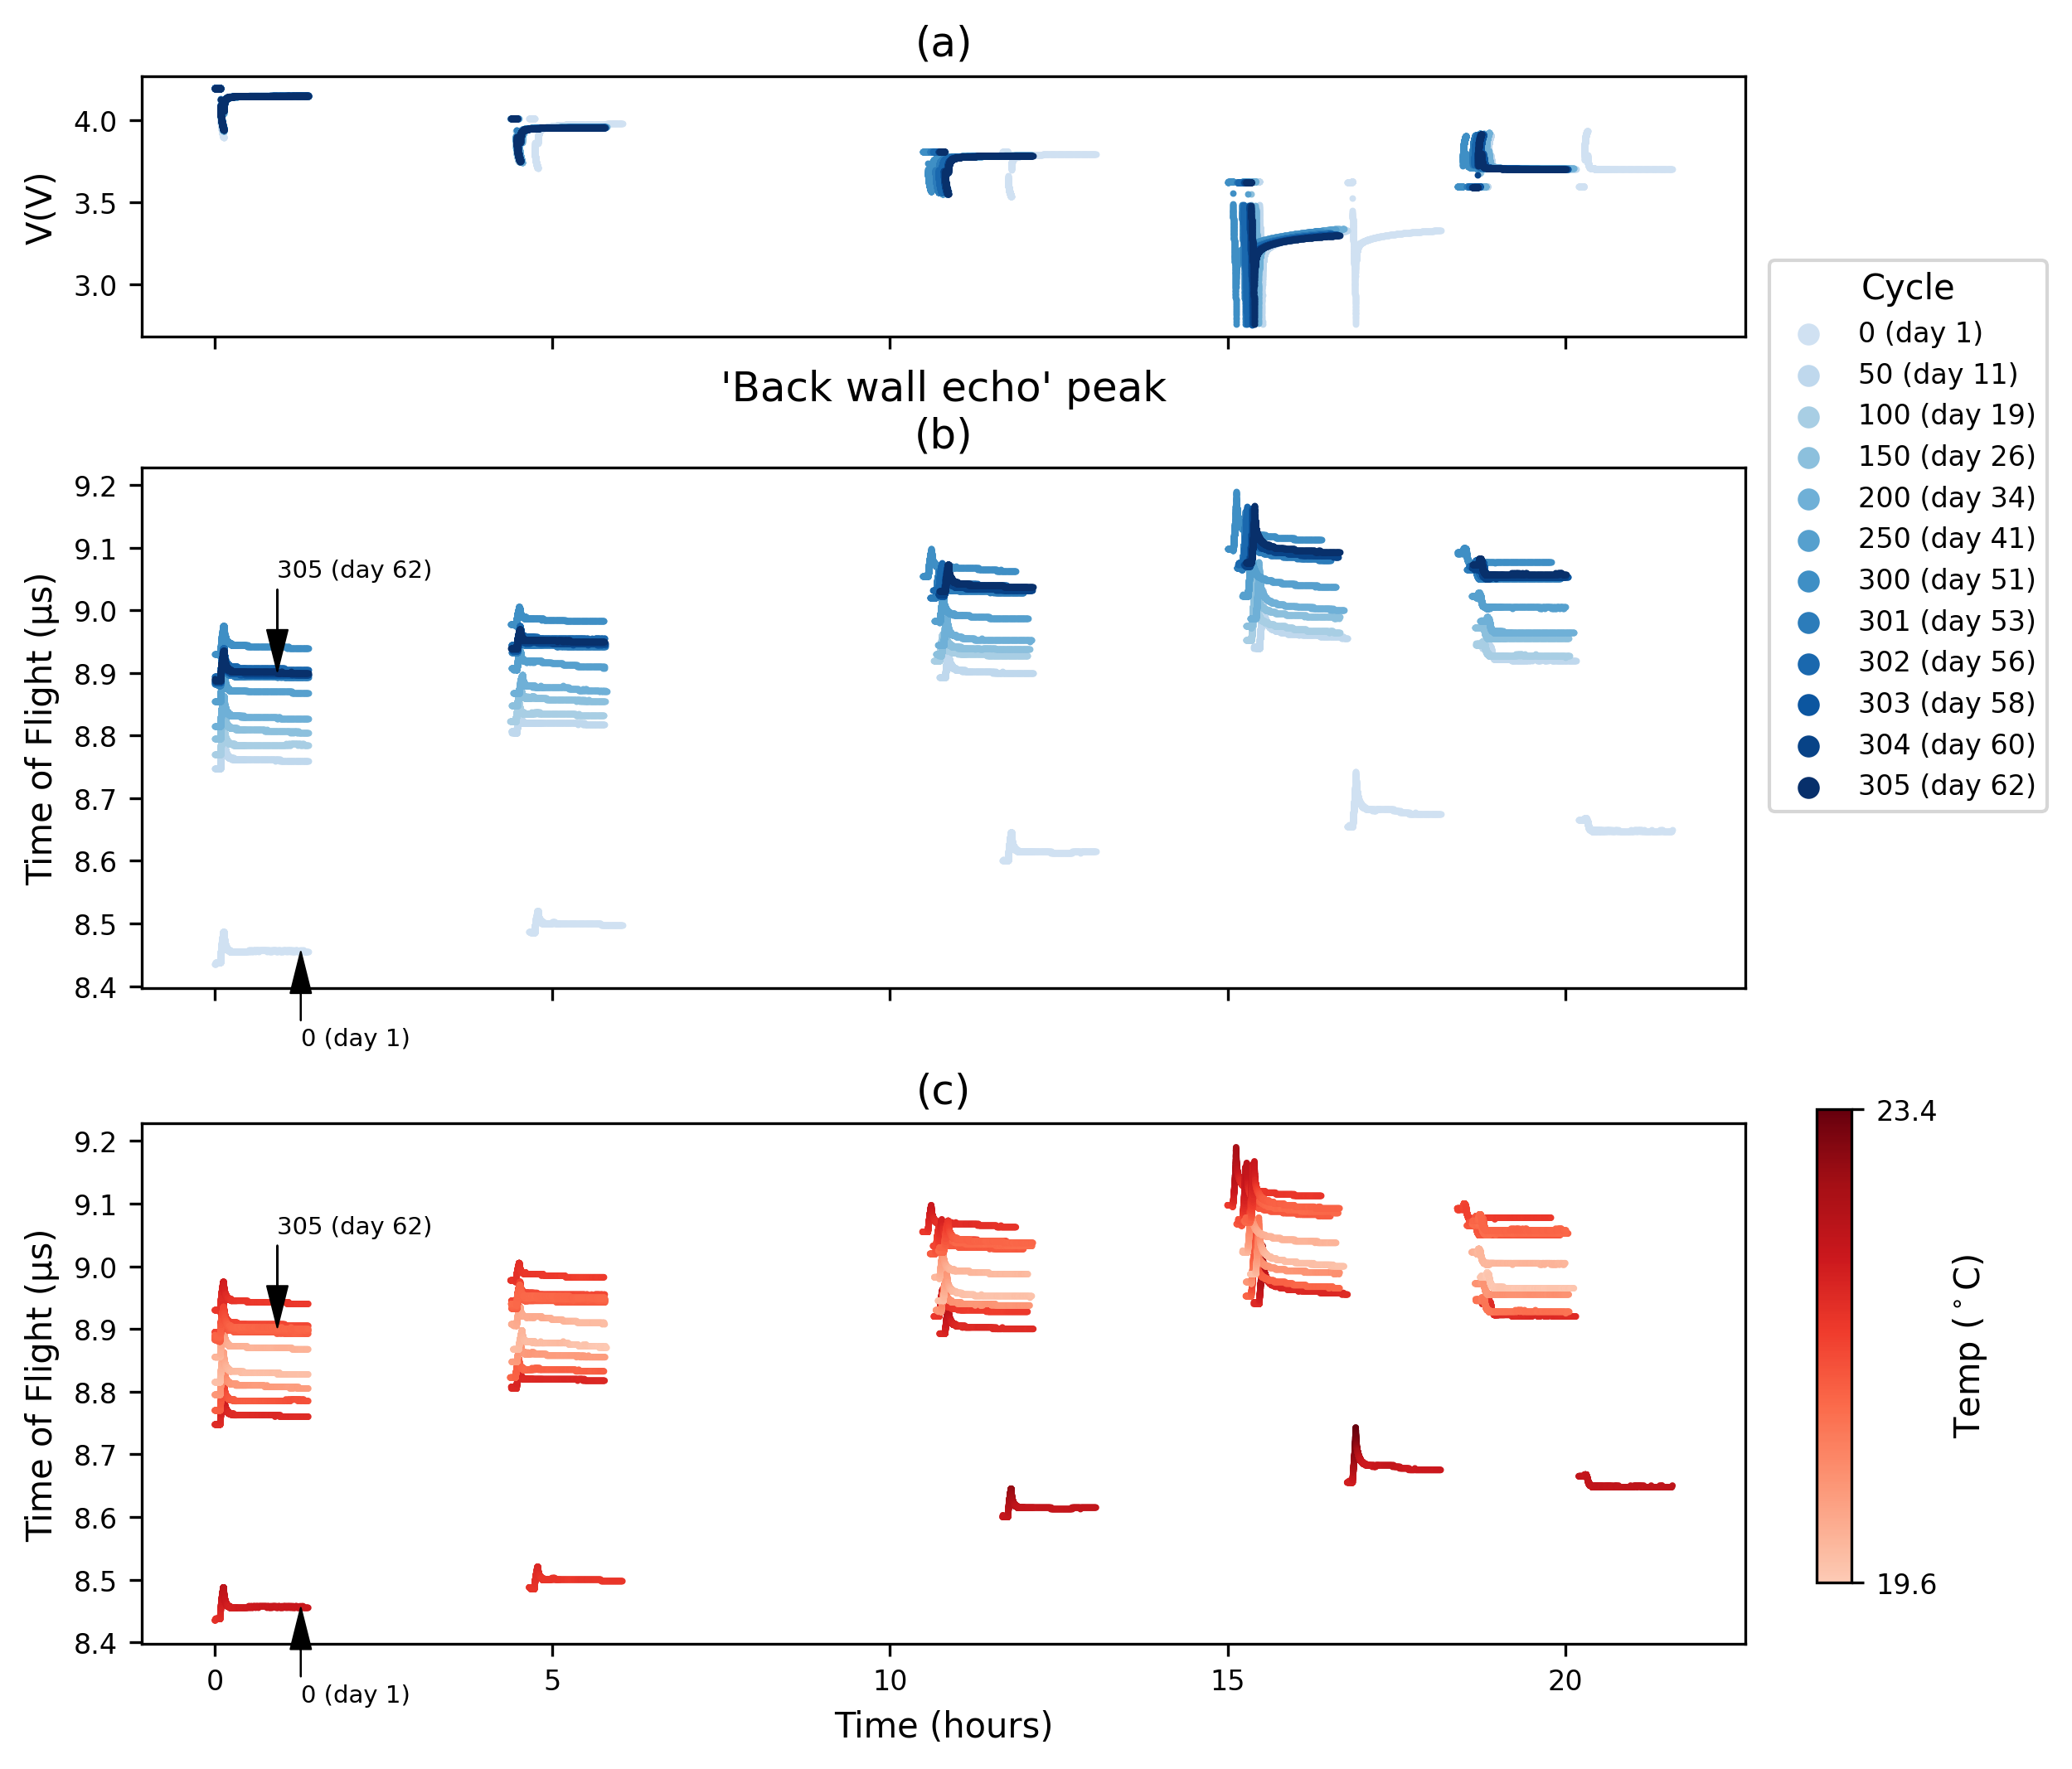

In [3]:
scatter_s = 0.8
f, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 7),
            height_ratios=[1,2,2], dpi=300, constrained_layout=True)
f.patch.set_facecolor('white')
color_cycles = colorscheme(len(degr_tests))
min_temp = df[('cycling', 'Temp(degC)')].min()
max_temp = df[('cycling', 'Temp(degC)')].max()
norm = mpl.colors.Normalize(vmin = min_temp, vmax = max_temp)
for i in range(len(degr_tests)):
    c_cycle = next(color_cycles)
    #---------------------------------
    test_id = degr_tests['test_id'].iloc[i]
    test_dir = os.path.join(data_path, test_id)
    filter = df[('cycling', 'test_id')] == test_id
    df_sub = df.loc[filter].reindex()
    label = cycles_and_days[i]
    #---------------------------------
    Protocol_objects = utils.create_custom_object(test_id, test_dir)
    #---------------------------------
    x1 = df_sub['cycling'].loc[:, 'Time(s)'].to_numpy()/3600
    x2 = df_sub['cycling']['Time(s)'].to_numpy()/3600
    volts = df_sub['cycling'].loc[:, 'V(V)']
    # Voltage vs time
    axs[0].scatter(x1, volts, color=c_cycle, s=scatter_s, label=label)
    # Acoustic peaks vs time - coloured by cycle
    tofs = df_sub['peak_tofs'].to_numpy()[:,-1]
    axs[1].scatter(x2, tofs, color=c_cycle, s=scatter_s)
    # Acoustic peaks vs time - coloured by temperature
    temps_acoustics = df_sub[('cycling', 'Temp(degC)')].to_numpy()
    c_temp = temp_colorsheme(norm(temps_acoustics))
    axs[2].scatter(x2, tofs, color=c_temp, s=scatter_s)
    # Annotations
    if i in [0, 11, 12, 19]:
        vertical_shift = {0:-0.15, 11:0.15, 12:-0.15, 19:0.25}
        point = {0:700, 11:650, 12:1600, 19:280}
        x_annot = x2[point[i]]
        y_annot =tofs[point[i]]
        annotation_args = {'text': label, 'xy': (x_annot,y_annot),
            'xytext':(x_annot,y_annot+vertical_shift[i]), 'fontsize': 7, 'ha': 'left',
            'arrowprops': dict(facecolor='black', width=0.02, headwidth=6, linewidth=0.5)}
        axs[1].annotate(**annotation_args)
        axs[2].annotate(**annotation_args)

# Legend showing cycle colours
f.legend(loc='center left', bbox_to_anchor=(1, 0.7), title="Cycle", markerscale=6)
# Colorbar showing temperature colours
box = axs[2].get_position()
axColor = plt.axes([(box.x0 + box.width)*1.15, box.y0*0.9, 0.02, box.height])
cb = f.colorbar(cm.ScalarMappable(norm=norm, cmap=temp_colorsheme), ax =axs[2],
            cax = axColor,
            ticks=[min_temp, 24, 26, 28, max_temp],
            format = FormatStrFormatter("%.1f"))
cb.set_label(label='Temp ($^\circ$C)')
#
axs[0].set_ylabel('V(V)')
axs[0].set_title('(a)')
axs[1].set_title("'Back wall echo' peak\n(b)")
axs[2].set_title('(c)')
axs[1].set_ylabel('Time of Flight (μs)')
axs[2].set_ylabel('Time of Flight (μs)')
axs[-1].set_xlabel('Time (hours)')
f.align_ylabels()

save_filename = 'Exp1_full_protocols'
utils.save_figure(f, visualistion_path, save_filename, 'png')


In [4]:
# Isolate pulses
def make_grids(Pulse_direction = 'dischrg', Peak = -1):
    """
    Pulse_direction: 'dischrg' | 'chrg'
    """

    quantities = ['times', 'voltages', 'temps', 'tofs', # Will be represented as lists
                    'pre_pulse_ocv', 'post_pulse_ocv', # Will be numbers
                    'tofs_pre_means', 'tofs_post_means', 'tofs_delta_state',
                    'tofs_rise_pct', 'tofs_overshoot_pct', 'tofs_delta_state_pct',
                    'tofs_rise', 'tofs_overshoot',
                    'temps_pre_means', 'temps_post_means',
                    'temps_rise', 'temps_overshoot'
                    ]
    if Pulse_direction == 'dischrg':
        pulse_range = range(0, 4)
    elif Pulse_direction == 'chrg':
        pulse_range = range(0, 1)   
    #
    grids = {
        quantity: [] for quantity in quantities}

    # Loop through all the cycles
    for i in range(len(degr_tests)):       
        cycle_data = {
            quantity: [] for quantity in quantities}
        #
        test_id = degr_tests['test_id'].iloc[i]
        test_dir = os.path.join(data_path, test_id)
        filter = df[('cycling', 'test_id')] == test_id
        df_cycle = df.loc[filter].reindex()
        #
        Protocol_objects = utils.create_custom_object(test_id, test_dir)
        #
        if Pulse_direction == 'dischrg':
            acoustic_pulse_list = Protocol_objects.Acoustic_char_dischrg_seq.Acoustic_Pulse_list
        elif Pulse_direction == 'chrg':
            acoustic_pulse_list = Protocol_objects.Acoustic_char_chrg_seq.Acoustic_Pulse_list
        # ----------------------------
        # Loop through all the pulses
        for Pulse_id in pulse_range:
            # Get acoustic pulse characteristics
            acoustic_pulse = acoustic_pulse_list[Pulse_id]
            R_pre_start_ind = acoustic_pulse.R_pre_start_ind
            R_pre_end_ind = acoustic_pulse.R_pre_end_ind
            R_post_end_ind = acoustic_pulse.R_post_end_ind
            #
            filter2 = df_cycle.index.isin(range(R_pre_start_ind, R_post_end_ind)) # i.e. all the data for this pulse object.
            df_pulse = df_cycle.loc[filter2]
            time = df_pulse['cycling'].loc[:, 'Time(s)'].to_numpy()
            time = time - 2*time[0]+time[1] # shift time so it doesn't start at zero but at the vale of the first timestep.
            V = df_pulse['cycling'].loc[:, 'V(V)'].to_numpy()
            tofs = df_pulse['peak_tofs'].to_numpy()[:, Peak]
            tofs *= 1000 # Convert to nanoseconds
            tofs_pre_mean = np.average(tofs[:(R_pre_end_ind-R_pre_start_ind)])
            tofs_post_mean = np.average(tofs[-20:]) # average over the last 20 points of the post-pulse relaxation.
            temperature = df_pulse['cycling'].loc[:, 'Temp(degC)'].to_numpy()
            temperature_pre_mean = np.average(temperature[:(R_pre_end_ind-R_pre_start_ind)])
            temperature_post_mean = np.average(temperature[-20:])

            # Calculate what's needed to populate cycle_data
            cycle_data['times'].append(time)
            cycle_data['voltages'].append(V)
            cycle_data['temps'].append(temperature)
            cycle_data['tofs'].append(tofs)

            cycle_data['pre_pulse_ocv'].append(V[0])
            cycle_data['post_pulse_ocv'].append(V[-1])
            cycle_data['tofs_pre_means'].append(tofs_pre_mean)
            cycle_data['tofs_post_means'].append(tofs_post_mean)
            cycle_data['tofs_rise'].append(tofs.max() - tofs_pre_mean)
            cycle_data['tofs_overshoot'].append(tofs.max() - tofs_post_mean)
            cycle_data['tofs_delta_state'].append(abs(tofs_pre_mean - tofs_post_mean))

            cycle_data['tofs_rise_pct'].append(
                (tofs.max() - tofs_pre_mean)/tofs_pre_mean*100)
            cycle_data['tofs_overshoot_pct'].append(
                (tofs.max() - tofs_post_mean)/tofs_pre_mean*100)
            cycle_data['tofs_delta_state_pct'].append(
                (abs(tofs_pre_mean - tofs_post_mean))/tofs_pre_mean*100)

            cycle_data['temps_pre_means'].append(temperature_pre_mean)
            cycle_data['temps_post_means'].append(temperature_post_mean)
            cycle_data['temps_rise'].append(temperature.max()-temperature_pre_mean)
            cycle_data['temps_overshoot'].append(temperature.max()-temperature_post_mean)

            for quantity in ['voltages', 'temps', 'tofs']:
                try:
                    assert (len(cycle_data[quantity][-1]) == len(cycle_data['times'][-1]))
                except AssertionError:
                    print('Failed on pulse: {}'.format(Pulse_id))
                    print('Failed on quantity: {}'.format(quantity))           

        # Append data for this cycle to the grid
        for quantity in quantities:
            grids[quantity].append(cycle_data[quantity])

    def isolate_pulse_from_grid(grid):
        grids_dfs = []
        for Pulse_id in pulse_range:
            data = {}
            data['cycle'] = cycles_completed
            for quantity in quantities:
                data[quantity] = [cycle_list[Pulse_id] for cycle_list in grid[quantity]]
            grids_dfs.append(pd.DataFrame.from_dict(data = data))
        return grids_dfs
    
    return isolate_pulse_from_grid(grids)

grids_dischrg = make_grids(Pulse_direction = 'dischrg', Peak = -1)
grids_chrg = make_grids(Pulse_direction = 'chrg', Peak = -1)


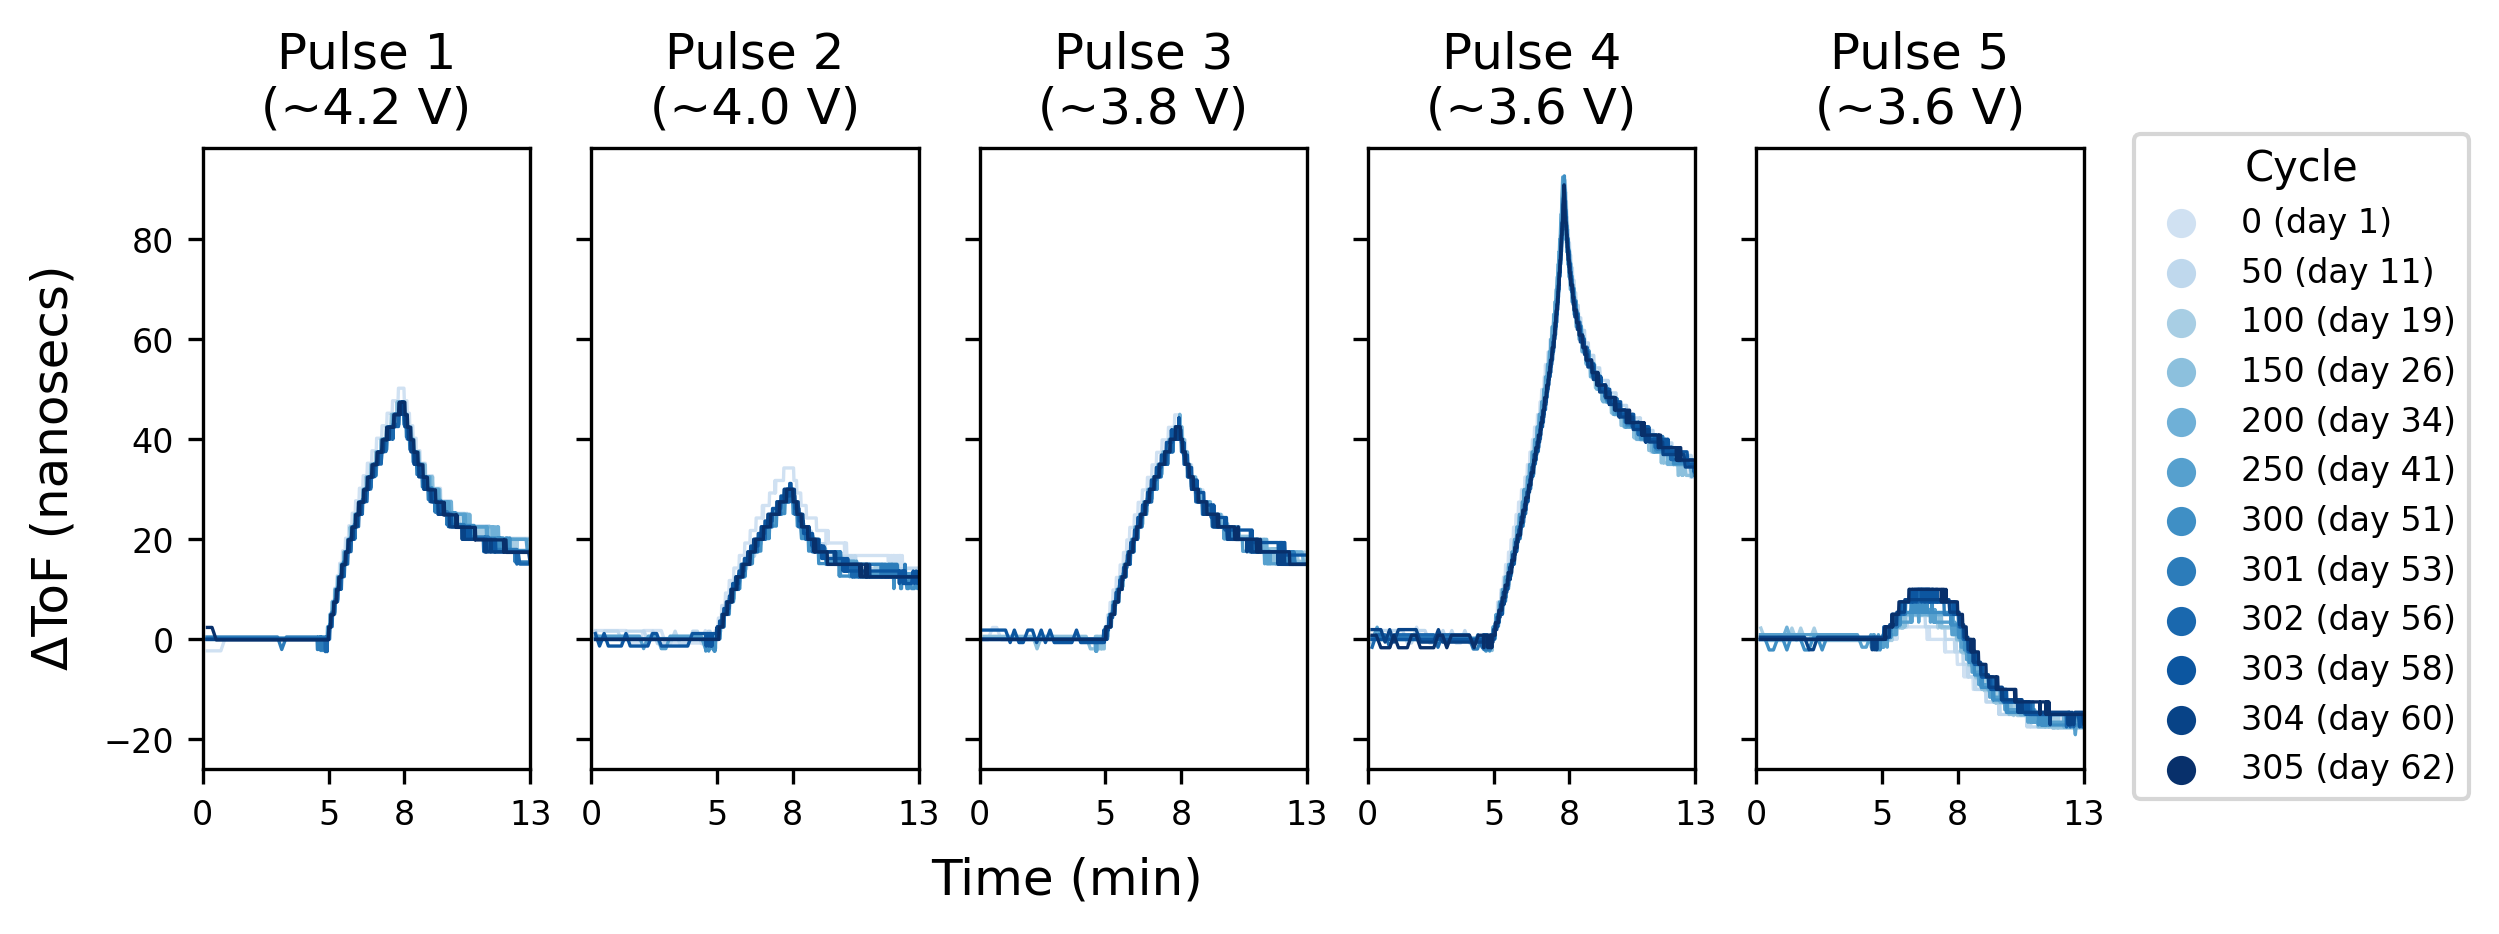

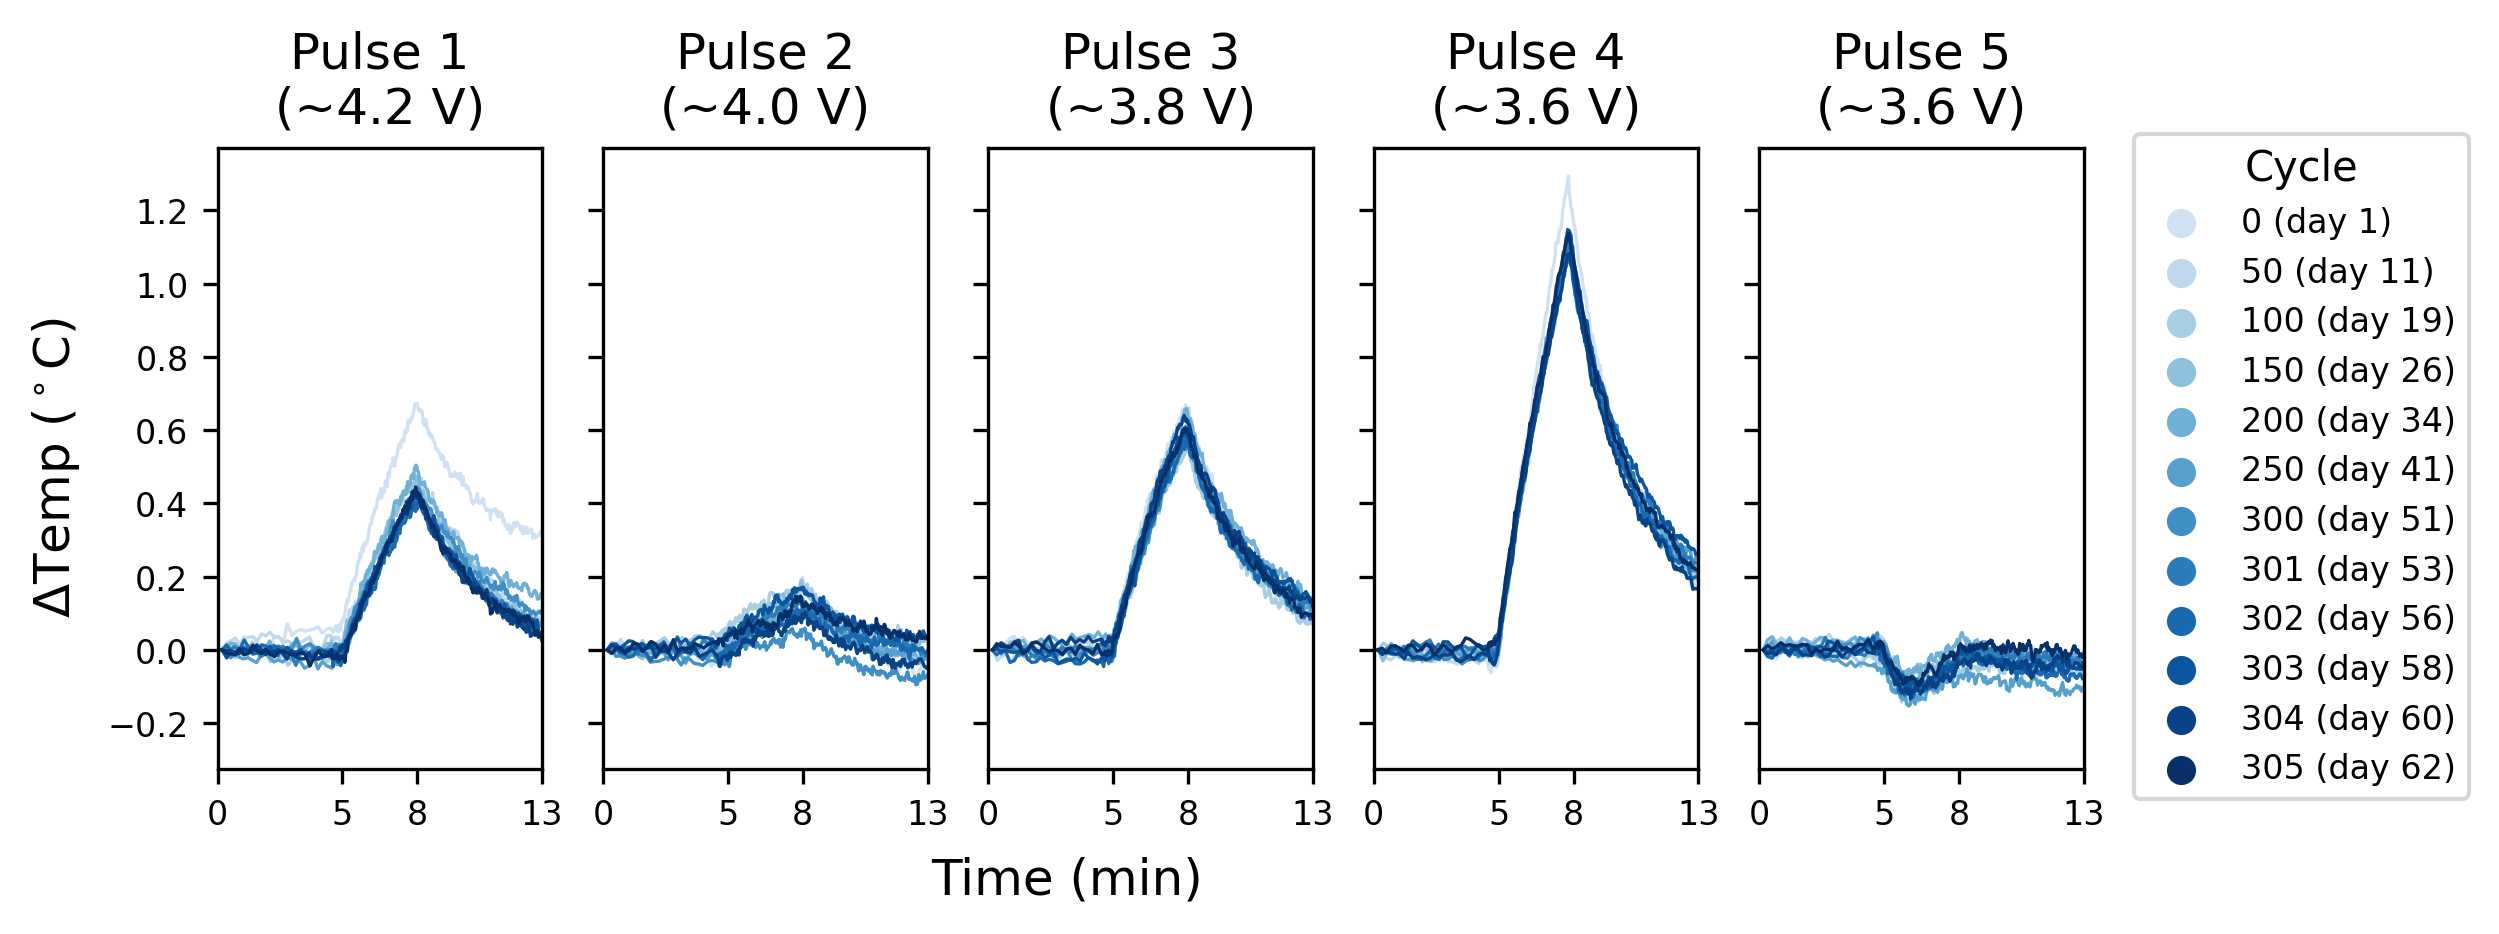

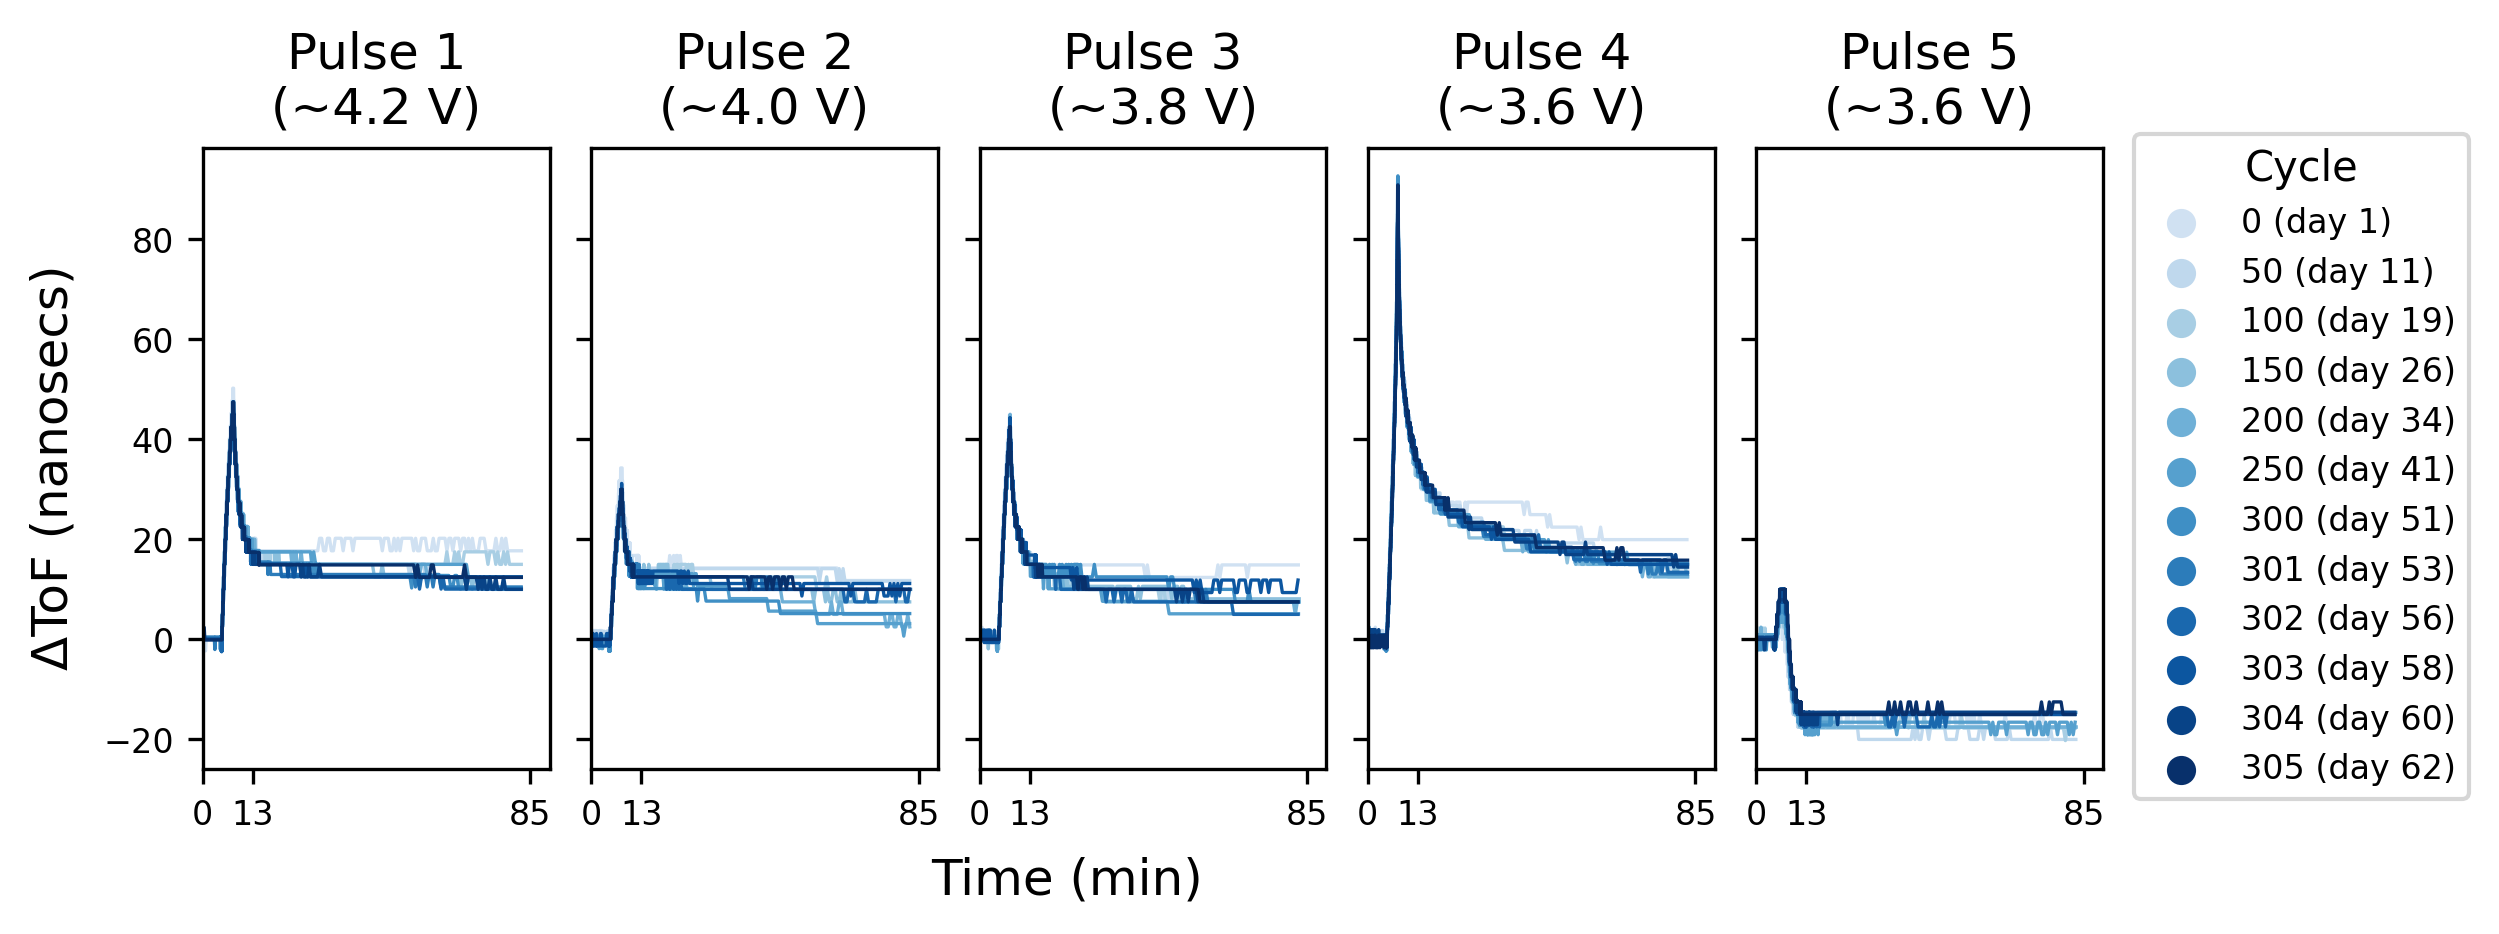

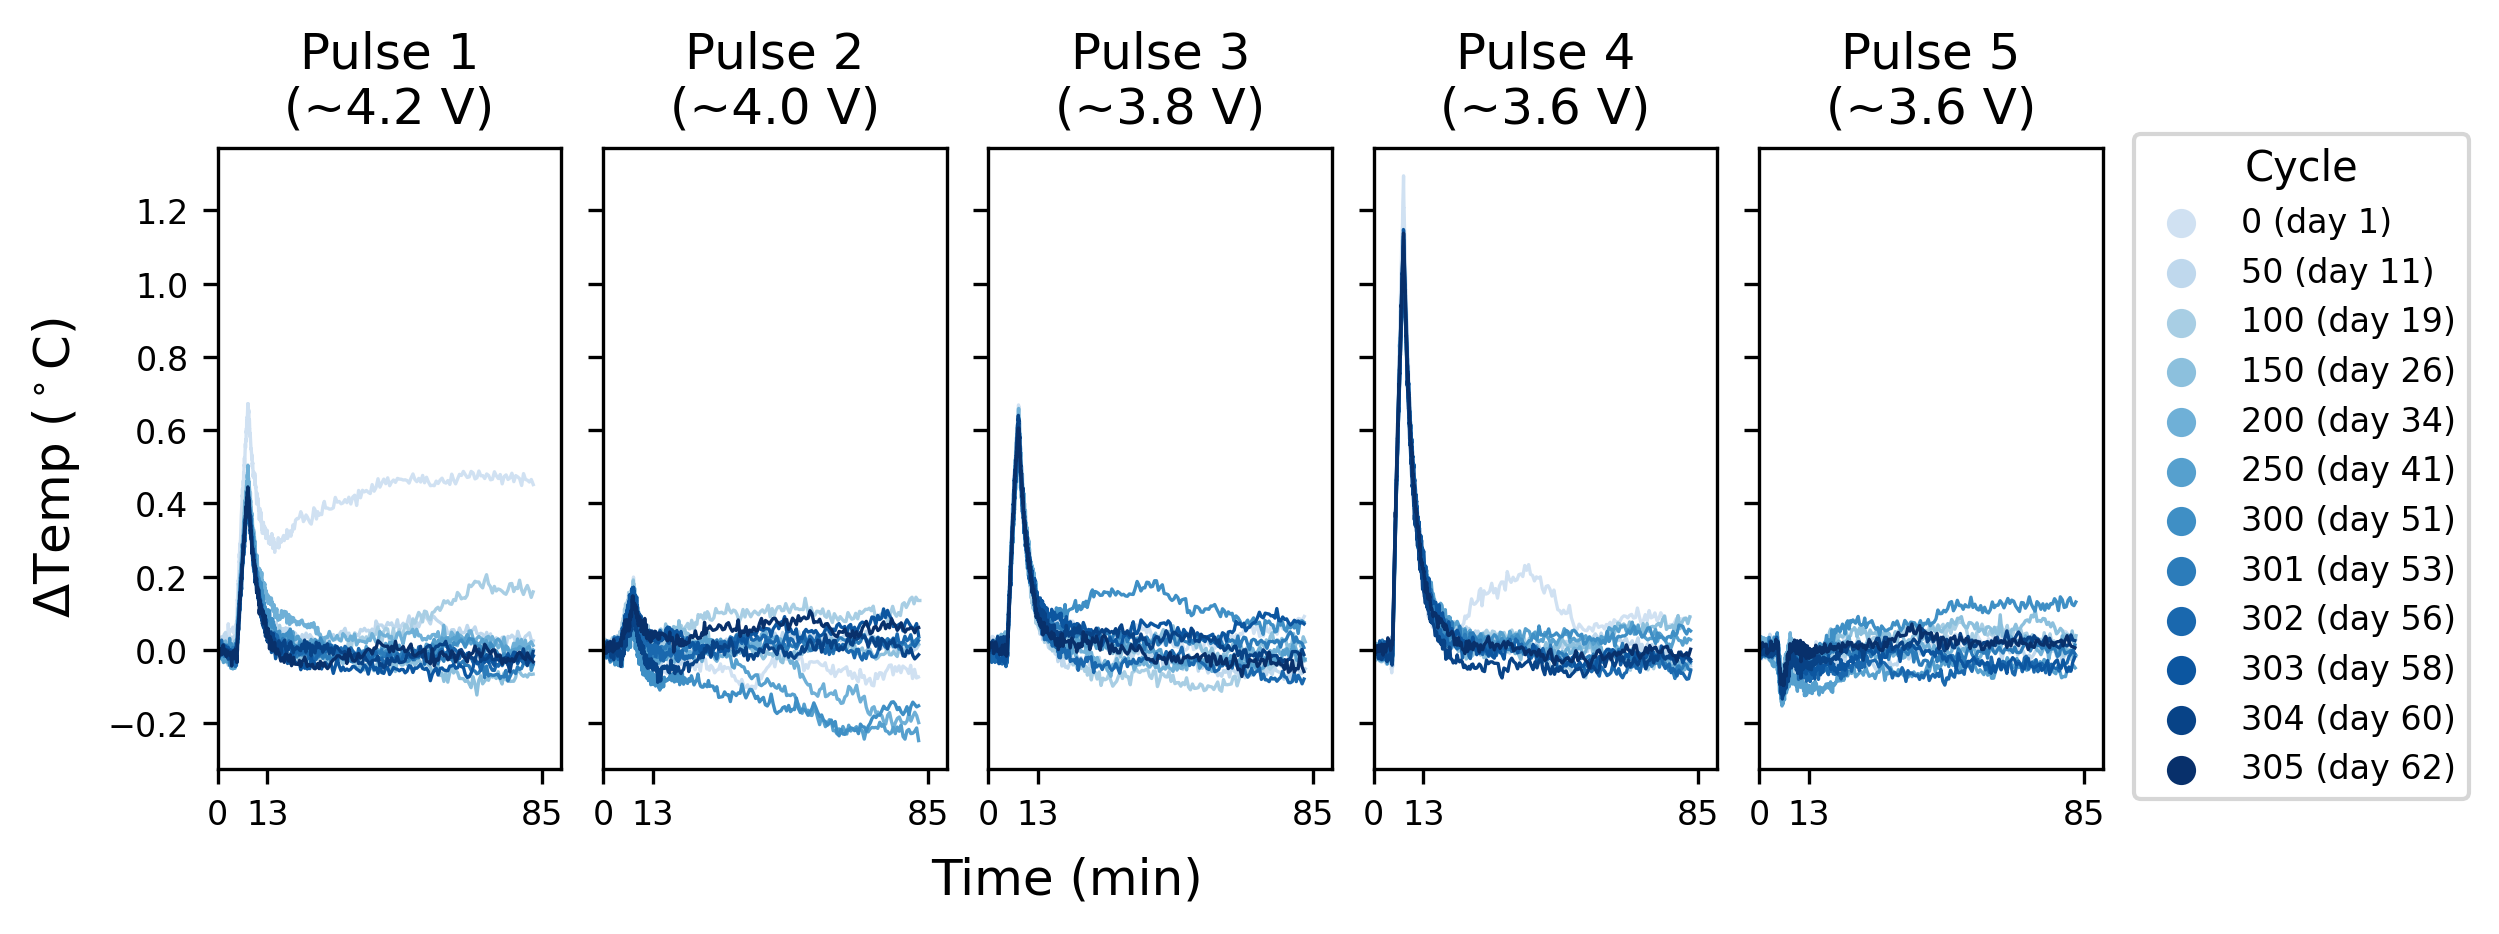

In [5]:
# Plot grid of degradation pulses for variable cycles
def plot_degr_pulses(color_by = 'cycle', y_quant = 'tof',
                     Pulse_direction = 'dischrg',
                     time_window = 'short'):
    """
    color_by: 'cycle' | 'temperature'
    Pulse_direction: 'dischrg' | 'chrg' | 'both'
    time_window: 'short' | 'long'
    """

    ocvs_dischrg = [4.2, 4, 3.8, 3.6]
    ocvs_chrg = [3.6]

    if Pulse_direction == 'dischrg':
        pulse_range = range(0, 4)
        grids = grids_dischrg
        nrows, ncols = 1, 4
        figsize=(6,2.5)
        ocvs = ocvs_dischrg
    elif Pulse_direction == 'chrg':
        pulse_range = range(0, 1)
        grids = grids_chrg
        nrows, ncols = 1, 2
        figsize=(5,2.5)
        ocvs = ocvs_chrg
    elif Pulse_direction == 'both':
        pulse_range = range(0, 5)
        grids = grids_dischrg
        grids.append(grids_chrg[0])
        nrows, ncols = 1, 5
        figsize=(7,3)
        ocvs = ocvs_dischrg
        ocvs.append(ocvs_chrg[0])

    if (color_by == 'temperature') | (Pulse_direction == 'chrg'):
        max_temp = 0
        min_temp = 100
        for Pulse_id in pulse_range:
            for i in range(len(degr_tests)):
                temperature = grids[Pulse_id].loc[i, 'temps']
                if temperature.max() > max_temp:
                    max_temp = temperature.max()
                if temperature.min() < min_temp:
                    min_temp = temperature.min()
        norm = mpl.colors.Normalize(vmin = min_temp, vmax = max_temp)

    f, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True,
                        figsize=figsize, dpi=300, constrained_layout=True)
    f.patch.set_facecolor('white')

    for count, Pulse_id in enumerate(pulse_range):
        if color_by == 'cycle':
            color = colorscheme(len(degr_tests))
        axs_column = count
        if (Pulse_direction == 'dischrg') | (Pulse_direction == 'both'):
            ax = axs[axs_column]
        else:
            ax = axs[0]
        for i in range(len(degr_tests)):
            label = cycles_and_days[i]
            
            if count==0:
                plot_args = {'label':label}
            else:
                plot_args = {}
            #---------------------------------
            time = grids[Pulse_id].loc[i, 'times']/60
            tof = grids[Pulse_id].loc[i, 'tofs']
            tof_pre_mean = grids[Pulse_id].loc[i, 'tofs_pre_means']
            temperature = grids[Pulse_id].loc[i, 'temps']

            if color_by == 'temperature':
                temperature = grids[Pulse_id].loc[i, 'temps']
                c = temp_colorsheme(norm(temperature))
                ax.scatter(
                        time, (tof-tof_pre_mean), color=c, s=0.3, **plot_args)
            elif color_by == 'cycle':
                c = next(color)
                if y_quant == 'tof':
                    ax.plot(
                        time, (tof-tof_pre_mean), color=c)
                elif y_quant == 'temperature':            
                    ax.plot(
                        time, (temperature-temperature[0]), color=c)
                ax.scatter([],[], color=c, **plot_args)
            #---------------------------------
        
        if (Pulse_direction == 'dischrg') | (Pulse_direction == 'both'):
            title = 'Pulse {}\n(~{:.1f} V)'.format(Pulse_id+1, ocvs[Pulse_id])
            ax.set_title(title)
        else:
            title = 'Pulse 5 (charging pulse)\n(~3.6 V)'
        
    if time_window == 'short':
        axs[0].set_xlim([0, 13])
        axs[0].set_xticks([0, 5, 8, 13])
    elif time_window == 'long':
        axs[0].set_xlim([0, 90])
        axs[0].set_xticks([0, 13, 85])

    if color_by == 'cycle':
        f.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Cycle", markerscale=6)
    elif color_by == 'temperature':
        if Pulse_direction == 'dischrg':
            cbar_axs = axs[-1]
            pad=0.2
            ticks=[min_temp, 24, 26, 28, max_temp]
        else:
            cbar_axs = axs
            ticks=[min_temp, 24, 26, max_temp]
            pad=0.05
        cb = f.colorbar(cm.ScalarMappable(norm=norm, cmap=temp_colorsheme), ax = cbar_axs,
                ticks=ticks, pad=pad, shrink=0.8,
                format = FormatStrFormatter("%.1f"))
        cb.set_label(label='Temp ($^\circ$C)')

    if Pulse_direction == 'chrg':
        Pulse_id = 0
        for i in range(len(degr_tests)):
            time = grids[Pulse_id].loc[i, 'times']/60
            tof = grids[Pulse_id].loc[i, 'tofs']
            tof_pre_mean = grids[Pulse_id].loc[i, 'tofs_pre_means']
            temperature = grids[Pulse_id].loc[i, 'temps']
            c = temp_colorsheme(norm(temperature))
            axs[1].scatter(time, (tof-tof_pre_mean), color=c, s=0.3)
        cb = f.colorbar(cm.ScalarMappable(norm=norm, cmap=temp_colorsheme), ax = axs[1],
                ticks=[min_temp, max_temp], shrink=0.8,
                format = FormatStrFormatter("%.1f"))
        cb.set_label(label='Temp ($^\circ$C)')        
        f.suptitle(title)

    f.align_ylabels()
    f.supxlabel('Time (min)')
    if y_quant == 'tof':
        f.supylabel('ΔToF (nanosecs)')
    elif y_quant == 'temperature':
        f.supylabel('ΔTemp ($^\circ$C)')
    
    return f

f = plot_degr_pulses(color_by = 'cycle', Pulse_direction = 'both', time_window='short')
save_filename = 'Exp1_pulses_tof_short'
utils.save_figure(f, visualistion_path, save_filename, 'png')

f = plot_degr_pulses(color_by = 'cycle', Pulse_direction = 'both', time_window='short',
                     y_quant='temperature')
save_filename = 'Exp1_pulses_temp_short'
utils.save_figure(f, visualistion_path, save_filename, 'png')

f = plot_degr_pulses(color_by = 'cycle', Pulse_direction = 'both', time_window='long')
save_filename = 'Exp1_pulses_tof_long'
utils.save_figure(f, visualistion_path, save_filename, 'png')

f = plot_degr_pulses(color_by = 'cycle', Pulse_direction = 'both', time_window='long',
                     y_quant='temperature')
save_filename = 'Exp1_pulses_temp_long'
utils.save_figure(f, visualistion_path, save_filename, 'png')


In [6]:
# For later labelling
quantity_labels = {
    'cycle': 'Cycle number',
    'tofs_rise': '$\mathrm{ΔToF_{rise}}$\n(nanoseconds)',
    'tofs_rise_pct': '$\mathrm{ΔToF_{rise}}$\n(%)',
    'temps_pre_means': '$\mathrm{T_0}$ ($^\circ$C)',
    'temps_rise': '$\mathrm{ΔTemp_{rise}}$\n($^\circ$C)',
    'pre_pulse_ocv': 'OCV (V)\nbefore\npulse',
}
quantity_labels_unitless = {
    'cycle': 'Cycle',
    'tofs_rise': '$\mathrm{ΔToF_{rise}}$',
    'temps_pre_means': '$\mathrm{T_0}$',
    'temps_rise': '$\mathrm{ΔTemp_{rise}}$',
    'pre_pulse_ocv': 'OCV\nbefore\npulse',
}


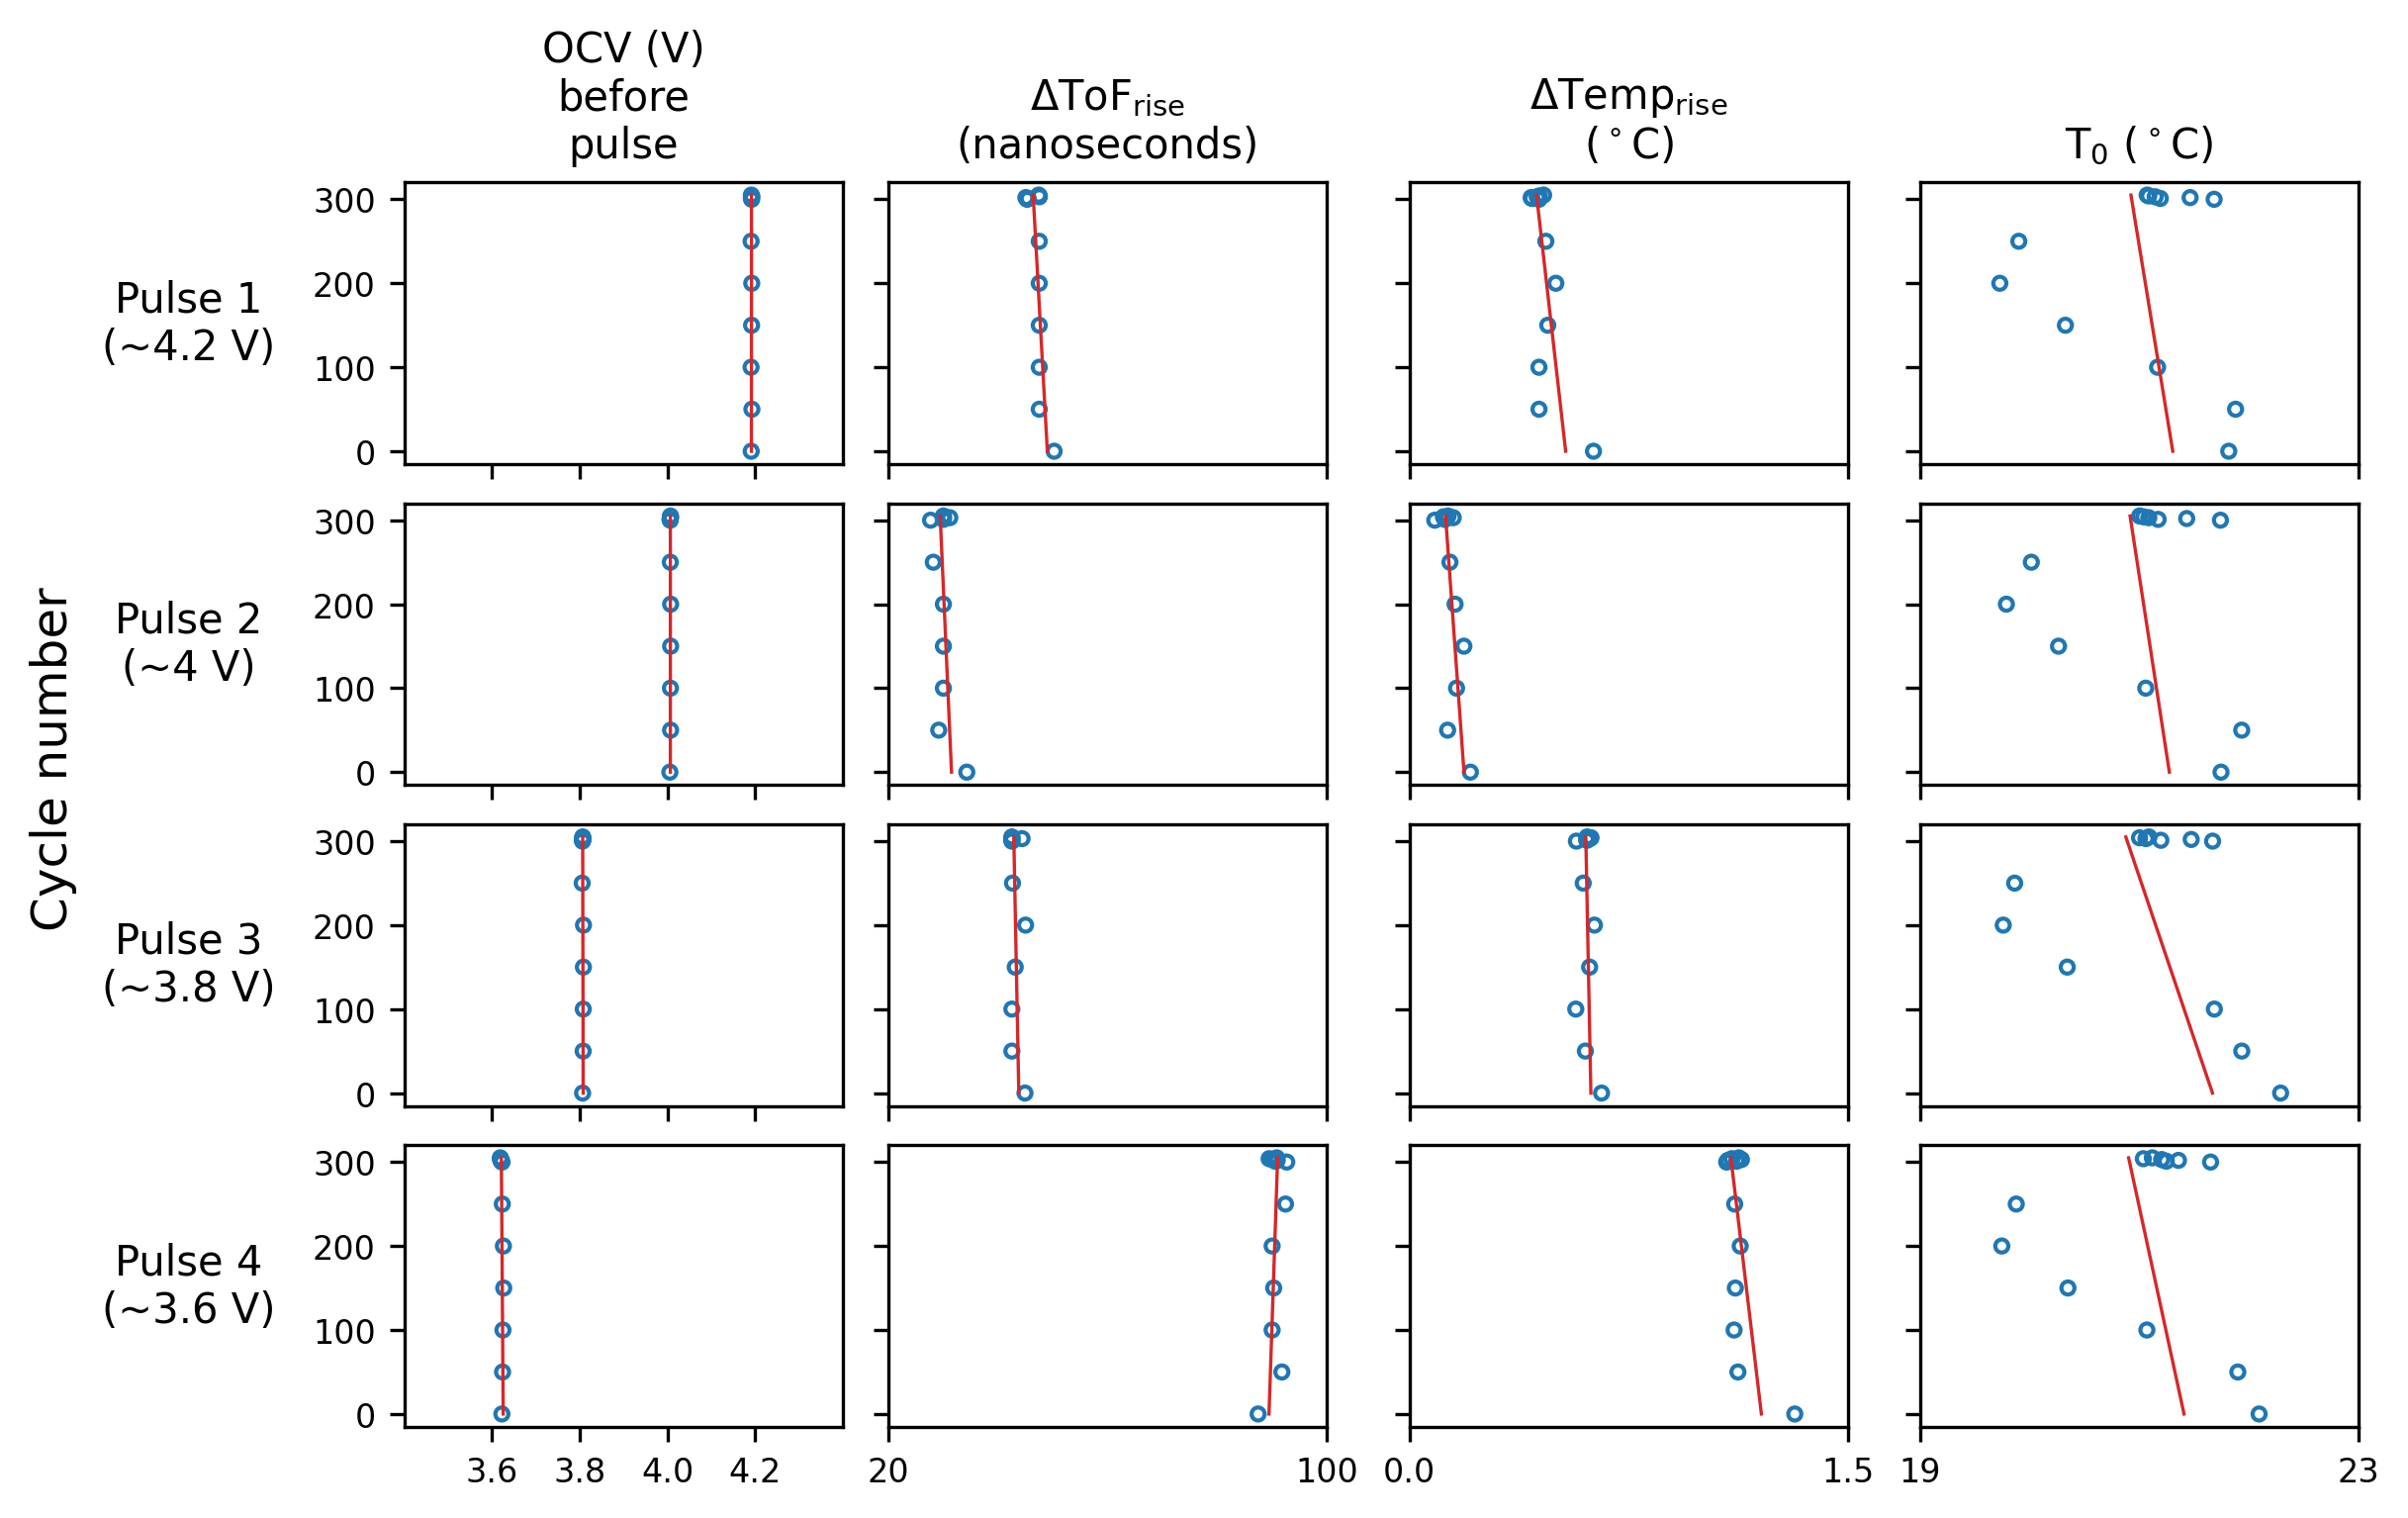

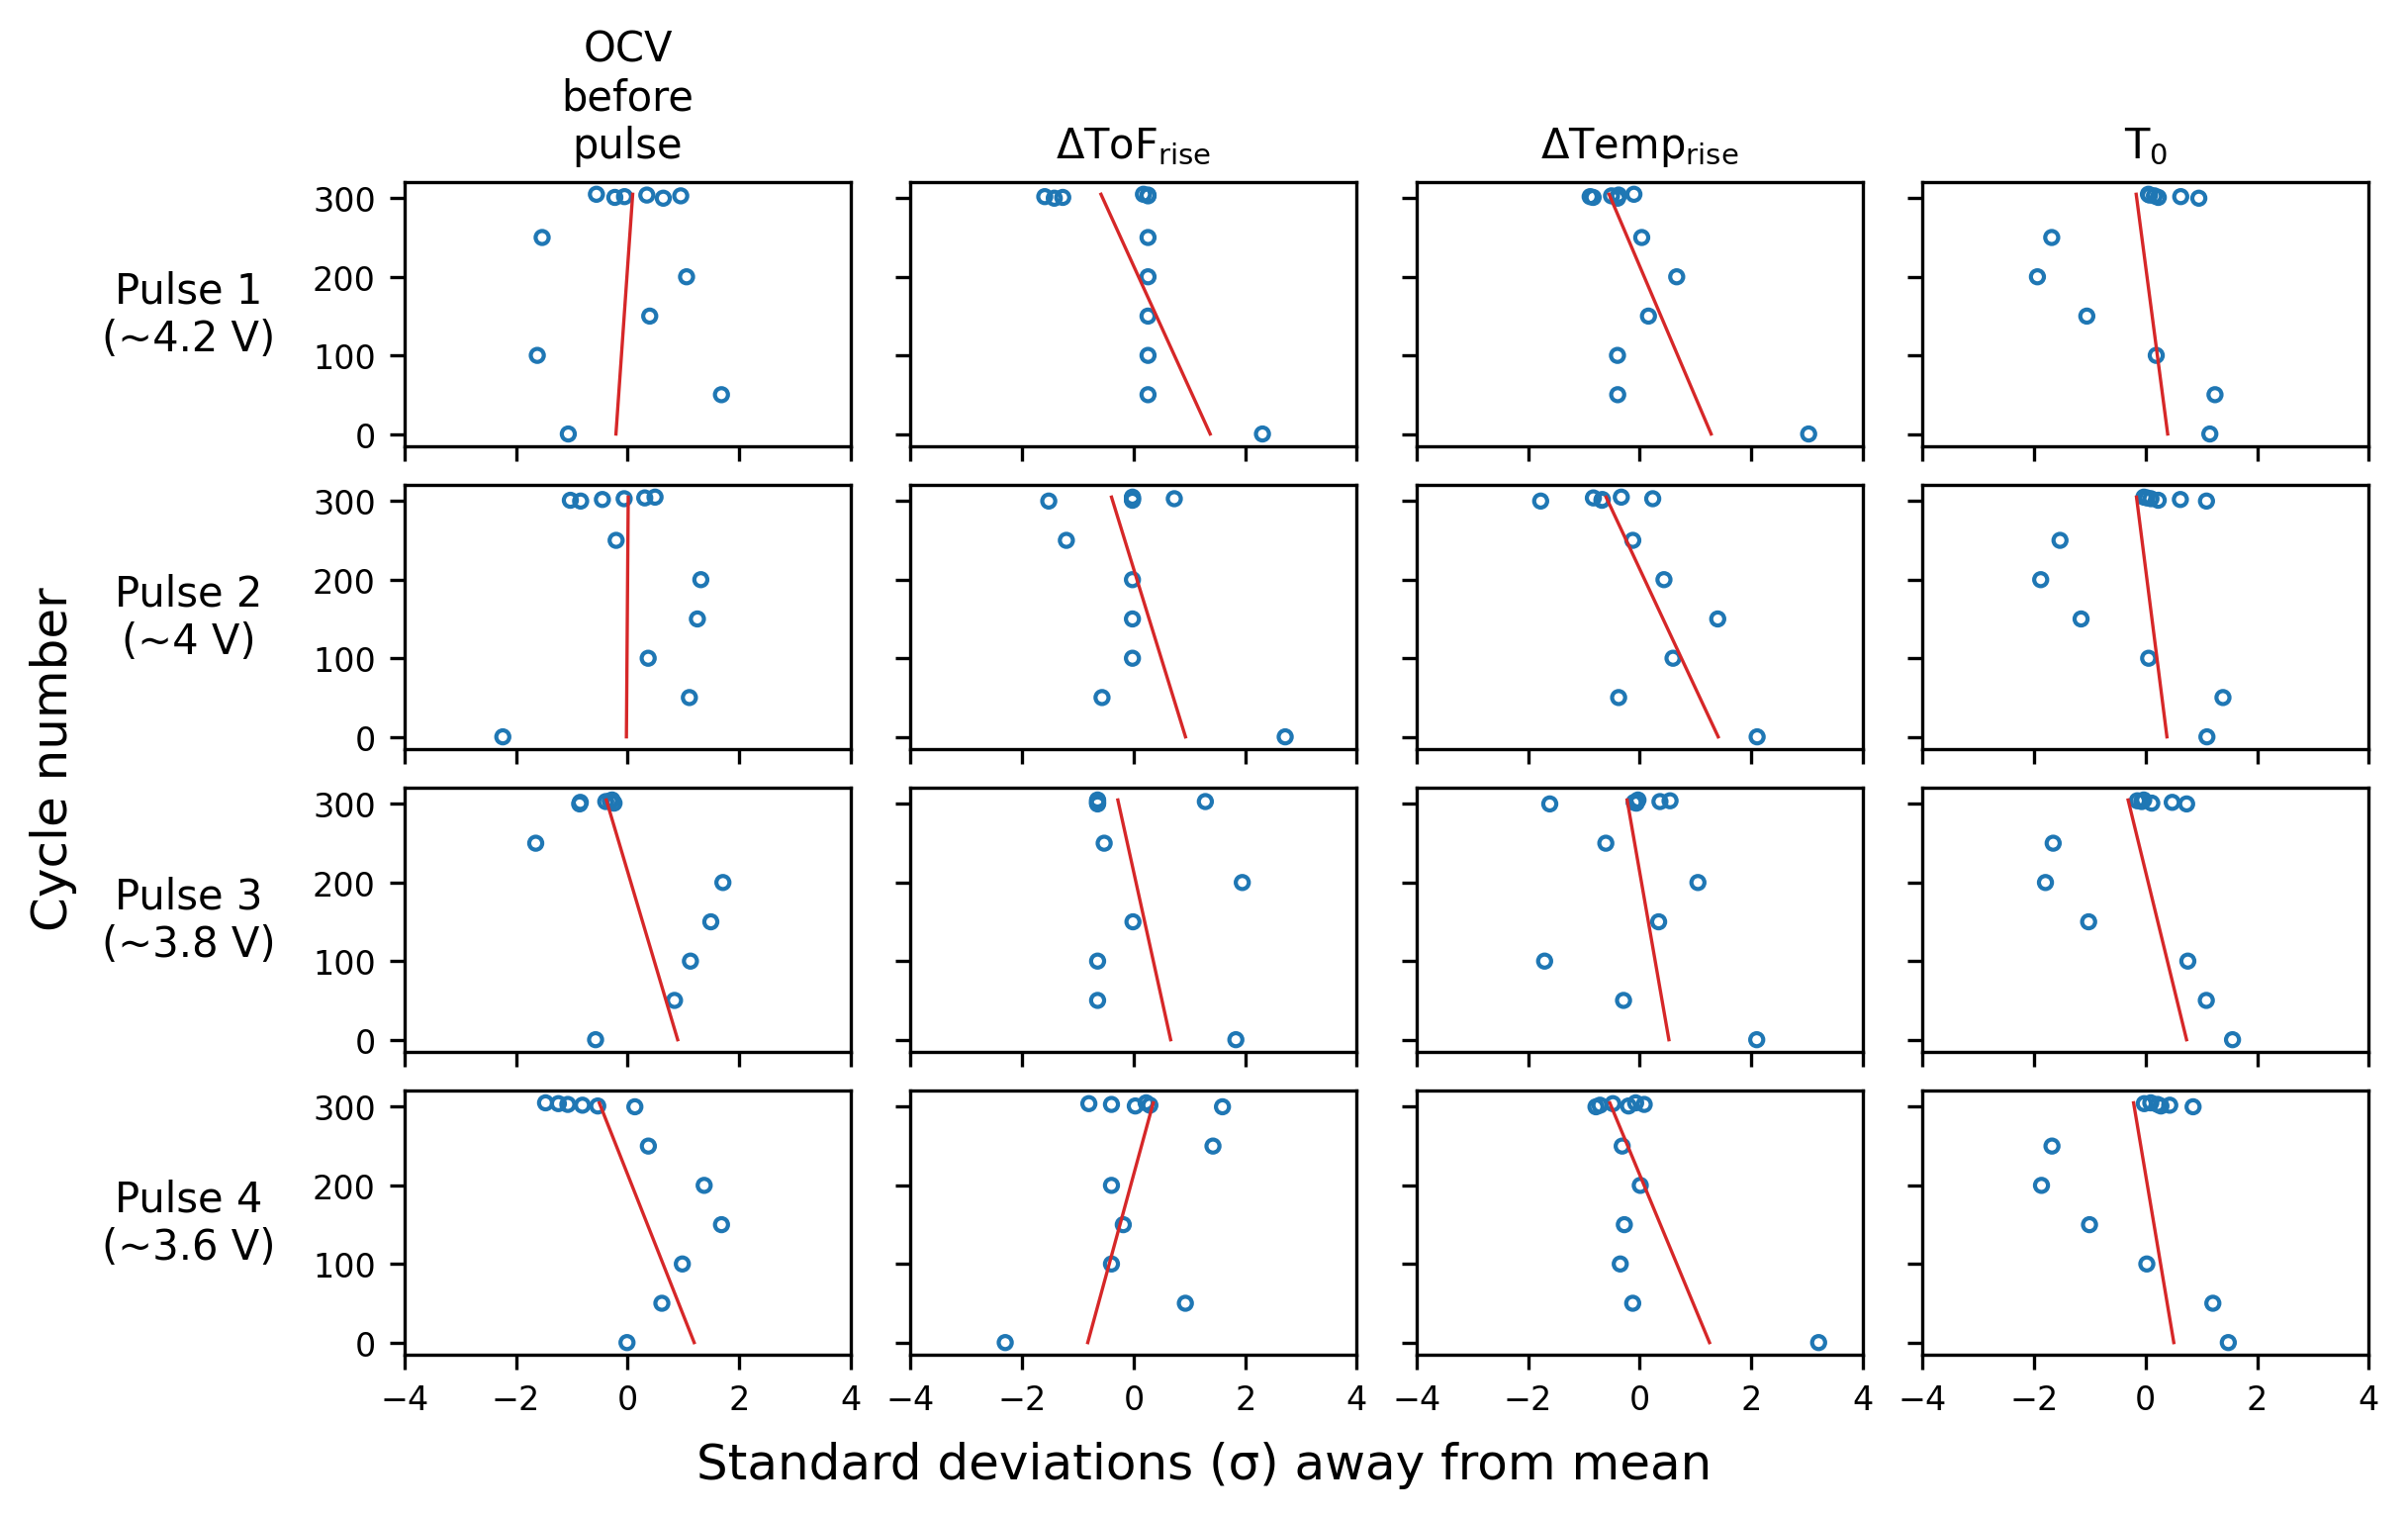

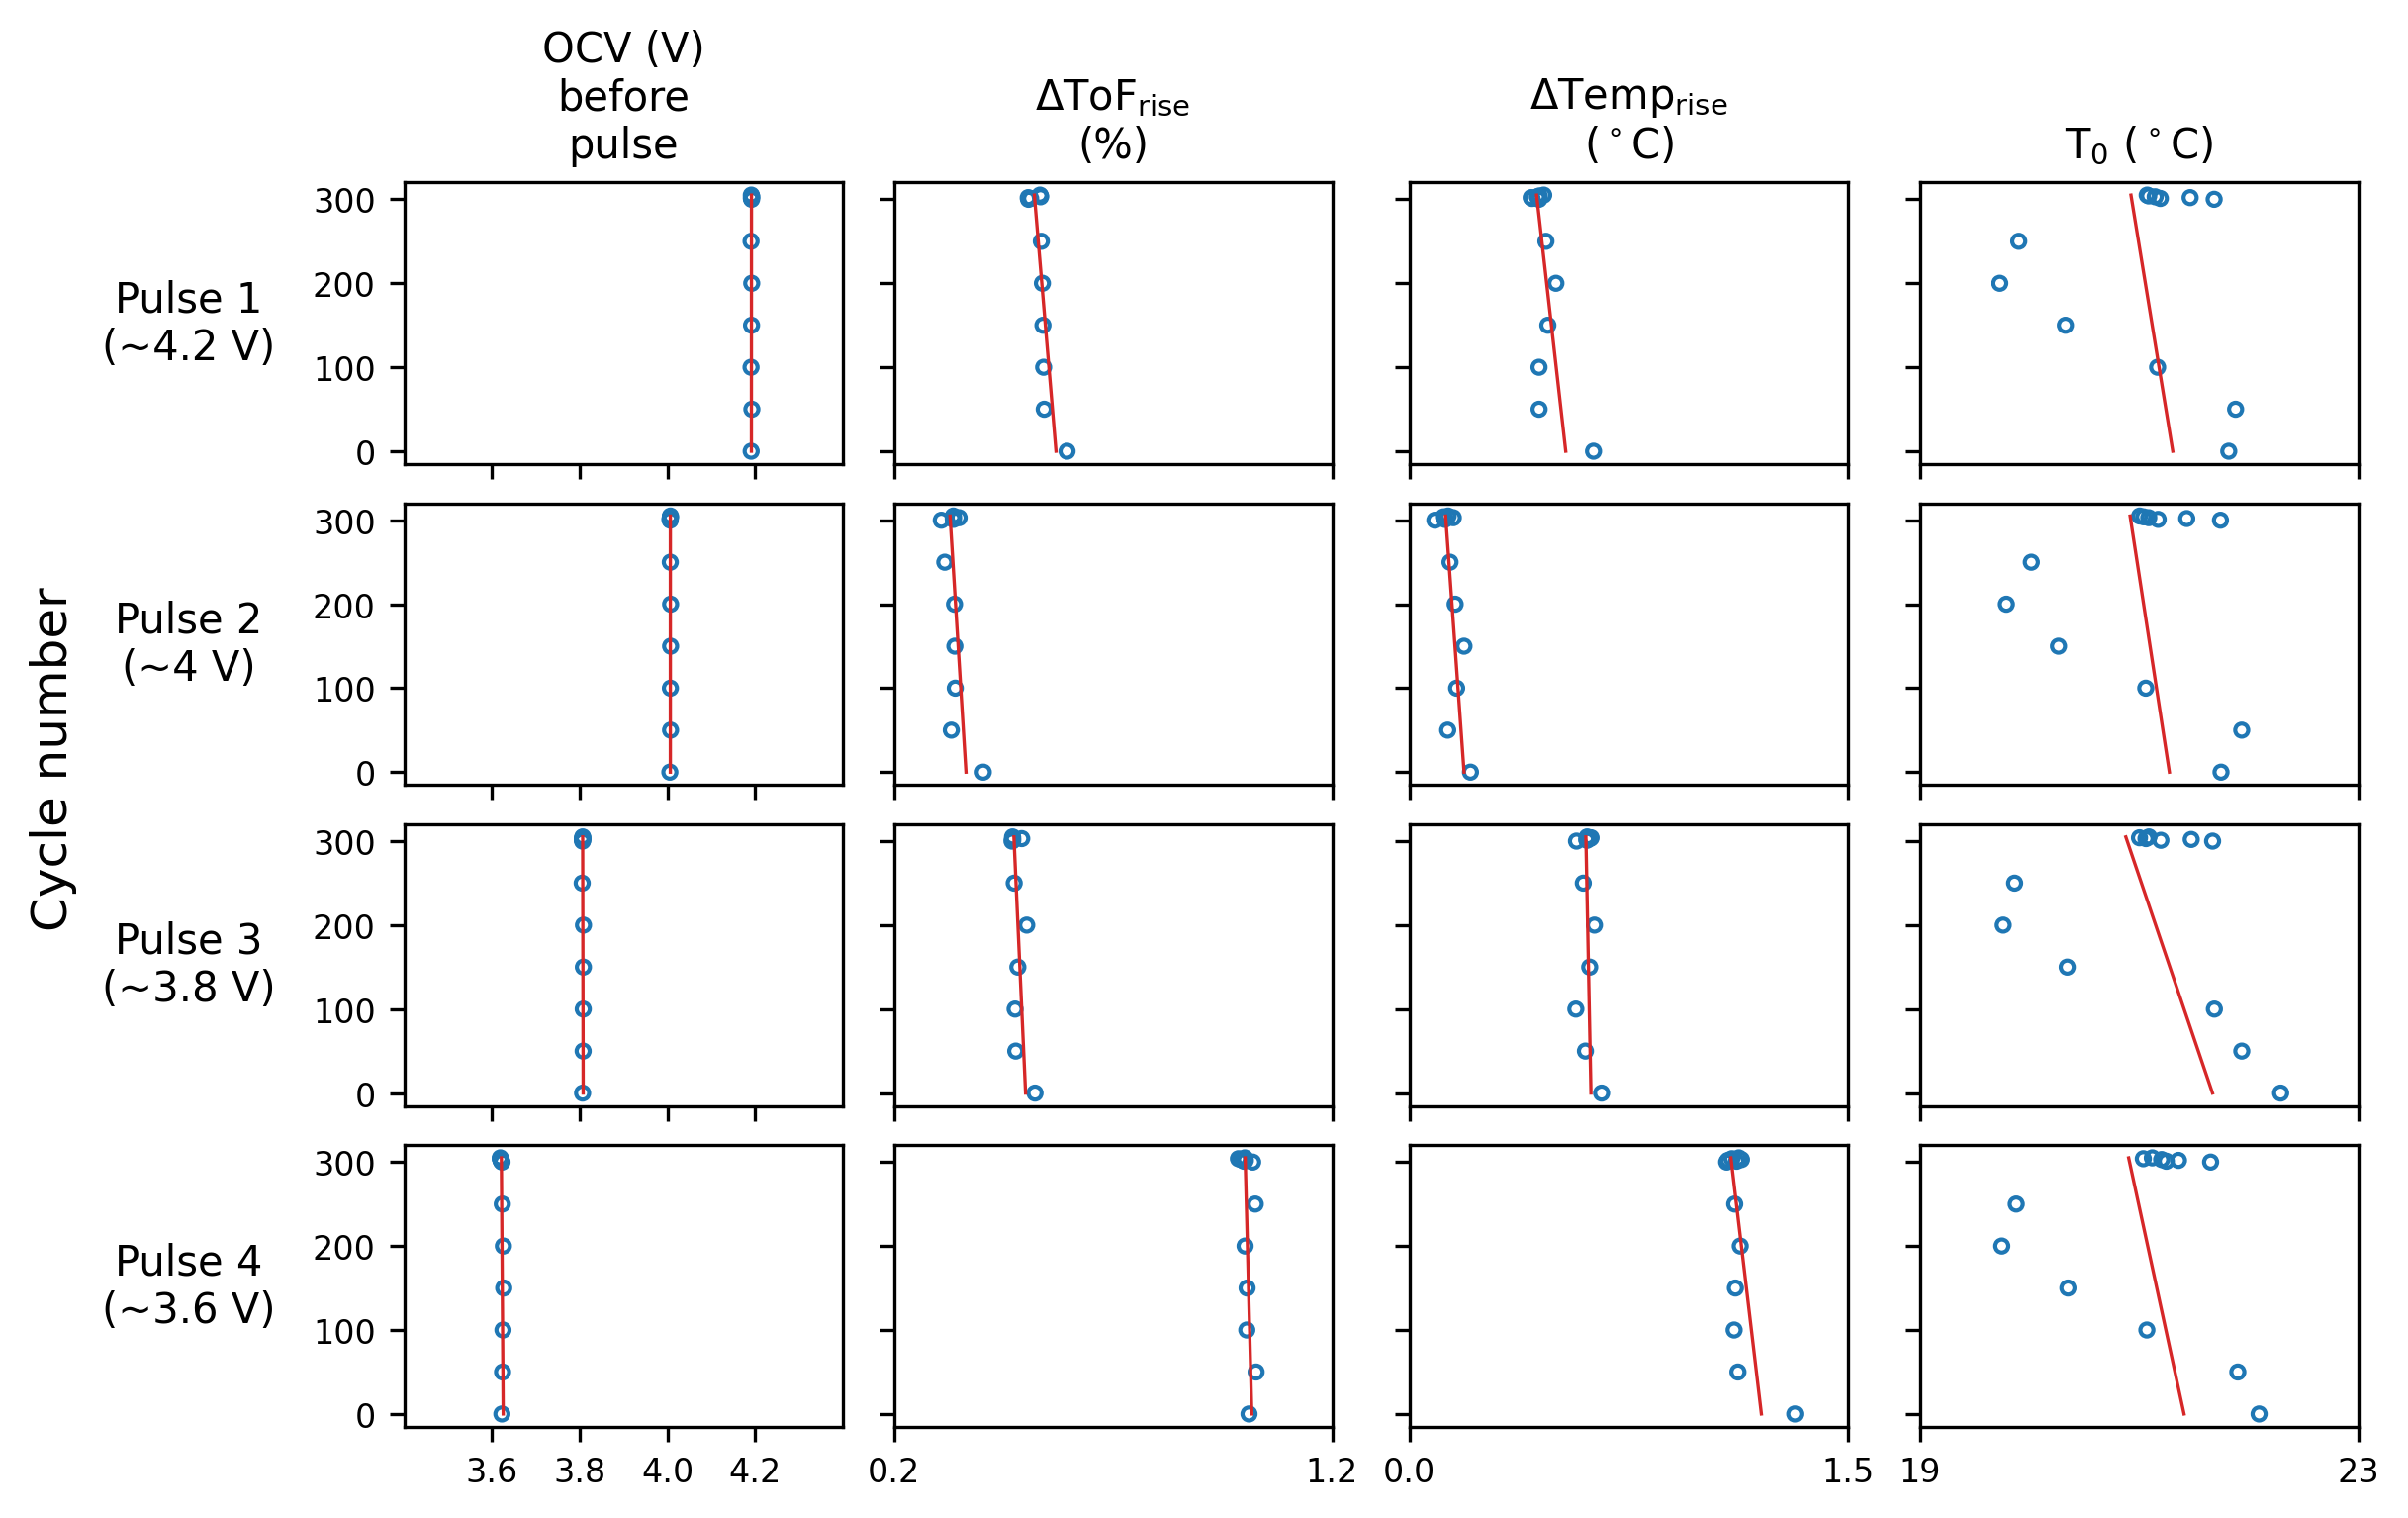

In [7]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import spearmanr

def pairwise_plot(y_quant = 'cycle', standardise=True, Pulse_direction = 'dischrg',
                  regression=True, independent_axis='y', percentages = False):
    
    ocvs_dischrg = [4.2, 4, 3.8, 3.6]
    ocvs_chrg = [3.6]
    s=10

    independent_axis = 'y' # Important to get meaningful fits
    if y_quant == 'cycle':
        if percentages == False:
            quantities = ['pre_pulse_ocv', 'tofs_rise','temps_rise', 'temps_pre_means']
        elif percentages == True:
            quantities = ['pre_pulse_ocv', 'tofs_rise_pct','temps_rise', 'temps_pre_means']

    if Pulse_direction == 'dischrg':
        pulse_range = range(0, 4)
        grids = grids_dischrg
        nrows, ncols = 4, len(quantities)
        figsize=(8,5)
        ocvs = ocvs_dischrg
    elif Pulse_direction == 'chrg':
        pulse_range = range(0, 1)
        grids = grids_chrg
        nrows, ncols = 1, len(quantities)
        figsize=(8,3)
        ocvs = ocvs_chrg

    Pearsons = {quantity: [] for quantity in quantities}
    Spearman = {quantity: [] for quantity in quantities}
    Regression_slopes = {quantity: [] for quantity in quantities}
    R2 = {quantity: [] for quantity in quantities}
    Standard_devs = {quantity: [] for quantity in quantities}

    if standardise==True:
        sharex=True
    else:
        sharex='col'

    f, axs = plt.subplots(nrows, ncols, figsize=figsize, sharey=True, sharex=sharex,
                constrained_layout=True, dpi=300)
    for Pulse_id in pulse_range:
        y = grids[Pulse_id].loc[:, y_quant].to_numpy()
        Y = np.array(y).reshape(-1,1)
        for j, x_quant in enumerate(quantities):
            x = grids[Pulse_id].loc[:, x_quant].to_numpy()
            if Pulse_direction == 'dischrg':
                ax = axs[Pulse_id, j]
            elif Pulse_direction == 'chrg':
                ax = axs[j]
            # Standardise if needed
            if standardise==True:
                z = (x-np.mean(x))/np.std(x)
                Z = np.array(z).reshape(-1,1)
            else:
                z = x
                Z = np.array(x).reshape(-1,1)
            # Plot scatter
            ax.scatter(Z,y,s=s, facecolors='none', edgecolors='tab:blue')
            # Perform linear regression:
            if regression == True:
                reg = LinearRegression(fit_intercept=True)
                if independent_axis == 'x':
                    reg.fit(Z, Y)
                    y_pred = reg.predict(Z)
                    if (standardise == True) | ((x_quant != 'pre_pulse_ocv') & (x_quant != 'post_pulse_ocv')):
                        ax.plot(Z, y_pred, color='tab:red')
                elif independent_axis == 'y':
                    reg.fit(Y, Z)
                    z_pred = reg.predict(Y)
                    ax.plot(z_pred, Y, color='tab:red')
                    residuals = z_pred-Z
                    RSS = np.sum(residuals**2)
                    TSS = np.sum((Z - np.mean(Z))**2)

                Regression_slopes[x_quant].append(reg.coef_[0][0])
                R2[x_quant].append(1-RSS/TSS)
                Pearsons[x_quant].append(pearsonr(z, y)[0])
                Spearman[x_quant].append(spearmanr(z, y)[0])
                Standard_devs[x_quant].append(np.std(x))

            if Pulse_id == 0:
                if standardise == True:
                    ax.set_title(quantity_labels_unitless[x_quant], fontsize=10)
                elif standardise == False:
                    ax.set_title(quantity_labels[x_quant], fontsize=10)

        if Pulse_direction == 'dischrg':
            ax = axs[Pulse_id, 0]
        elif Pulse_direction == 'chrg':
            ax = axs[0]

        ax.set_ylabel('Pulse {}\n(~{} V)'.format(Pulse_id+1, ocvs[Pulse_id]),
                      rotation=0, labelpad=30, va='center', fontsize=10)

    if standardise==True:
        if Pulse_direction == 'dischrg':
            ax = axs[-1, 0]
        elif Pulse_direction == 'chrg':
            ax = axs[-1]
        ax.set_xlim(-4.0, 4.0)
        f.supxlabel('Standard deviations (σ) away from mean')
    else:
        # Keep only 2 xticks, not more
        for j in range(axs.shape[1]):
            x_ticks = axs[-1,j].get_xticks()
            if len(x_ticks) > 2:
                axs[-1,j].set_xticks([x_ticks[0], x_ticks[-1]])

    f.supylabel(quantity_labels[y_quant])
    
    stats = {
        'Regression_slopes': Regression_slopes,
        'R2': R2,
        'Pearsons': Pearsons,
        'Spearman': Spearman,
        'Standard_devs': Standard_devs       
    }

    axs[0,0].set_yticks([0, 100, 200, 300])
    if standardise == False:
        axs[0,0].set_xticks(ocvs_dischrg)

    return f, stats

f, _ = pairwise_plot(y_quant = 'cycle', standardise=False)
save_filename = 'Exp1_pairwise'
utils.save_figure(f, visualistion_path, save_filename, 'png')

f, stats = pairwise_plot(y_quant = 'cycle', standardise=True)
save_filename = 'Exp1_pairwise_standardised'
utils.save_figure(f, visualistion_path, save_filename, 'png')

f, stats_pct = pairwise_plot(y_quant = 'cycle', standardise=False, percentages=True)


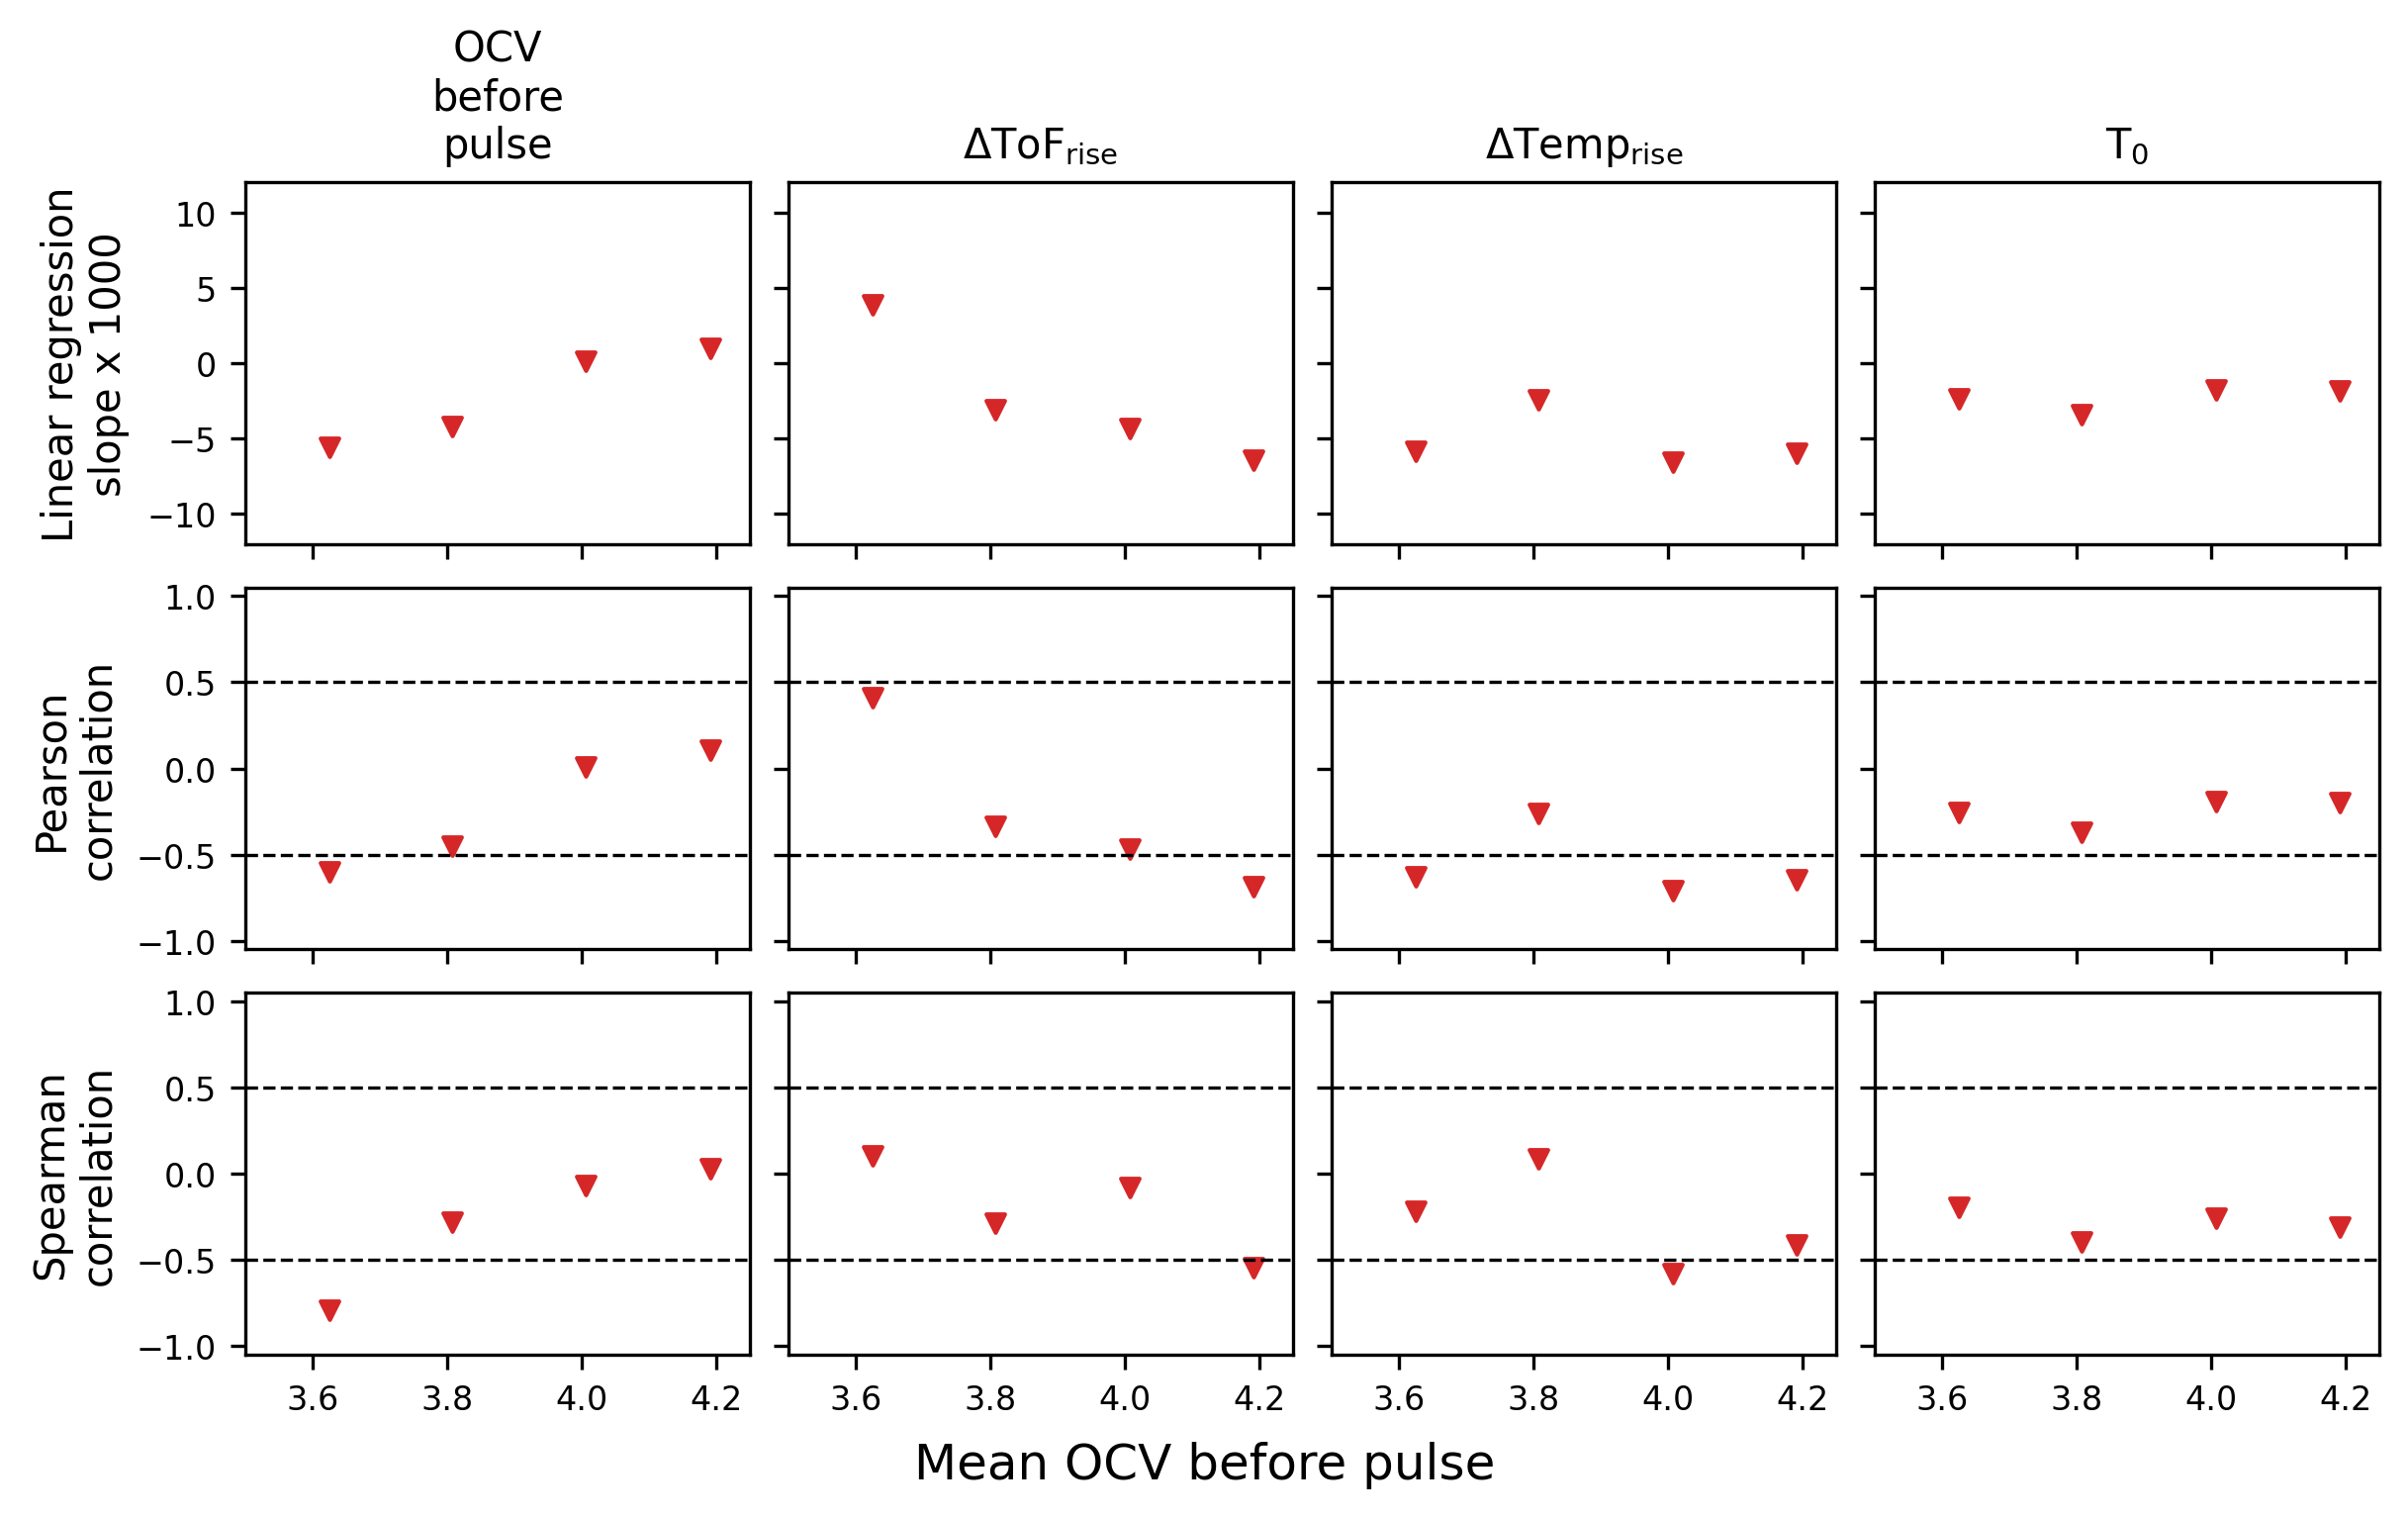

In [8]:
# Macro-trends: Regression
Regression_slopes = stats['Regression_slopes']
R2 = stats['R2']
Pearsons = stats['Pearsons']
Spearman = stats['Spearman']
Standard_devs = stats['Standard_devs']
Standard_devs_pct = stats_pct['Standard_devs']

ocvs_pre_mean = [4.19163571, 4.00666286, 3.80717429, 3.62407857]
quantities = ['pre_pulse_ocv', 'tofs_rise','temps_rise', 'temps_pre_means']

f, axs = plt.subplots(3, len(quantities), sharex=True, sharey='row',
        figsize=(8,5), constrained_layout=True, dpi=300)
f.patch.set_facecolor('white')

marker = 'v'
marker_s = 20
marker_c = 'tab:red'

for j, quantity in enumerate(quantities):
    # Convert voltage to mV
    axs[0,j].scatter(ocvs_pre_mean, np.array(Regression_slopes[quantity])*1000,
        color=marker_c, s=marker_s, marker=marker)
    axs[1,j].scatter(ocvs_pre_mean, Pearsons[quantity],
        color=marker_c, s=marker_s, marker=marker)
    axs[2,j].scatter(ocvs_pre_mean, Spearman[quantity],
        color=marker_c, s=marker_s, marker=marker)    

    axs[0,j].set_title(quantity_labels_unitless[quantity], fontsize=10)

axs[0,0].set_xlim(3.5, 4.25)
axs[0,0].set_xticks([3.6, 3.8, 4.0, 4.2])
axs[0,0].set_ylim(-12,12)
axs[1,0].set_ylim(-1.05, 1.05)
axs[1,0].set_yticks([-1, -0.5, 0, 0.5, 1])
axs[2,0].set_ylim(-1.05, 1.05)
axs[2,0].set_yticks([-1, -0.5, 0, 0.5, 1])

# Add dashed lines at correlation coefficients = +/- 0.5
for i in [1,2]:
    for j in range(len(quantities)):
        x_lim = axs[i,j].get_xlim()
        axs[i,j].plot([x_lim[0], x_lim[1]], [0.5,0.5], color='k', linestyle='dashed')
        axs[i,j].plot([x_lim[0], x_lim[1]], [-0.5,-0.5], color='k', linestyle='dashed')
        axs[i,j].set_xlim(x_lim)

# Label y axes
axs[0,0].set_ylabel('Linear regression\nslope x 1000',
    labelpad=15, ha='center', va='center')
axs[1,0].set_ylabel('Pearson\ncorrelation',
    labelpad=15, ha='center', va='center')
axs[2,0].set_ylabel('Spearman\ncorrelation',
    labelpad=15, ha='center', va='center')

f.supxlabel('Mean OCV before pulse')

save_filename = 'Exp1_correlations'
utils.save_figure(f, visualistion_path, save_filename, 'png')


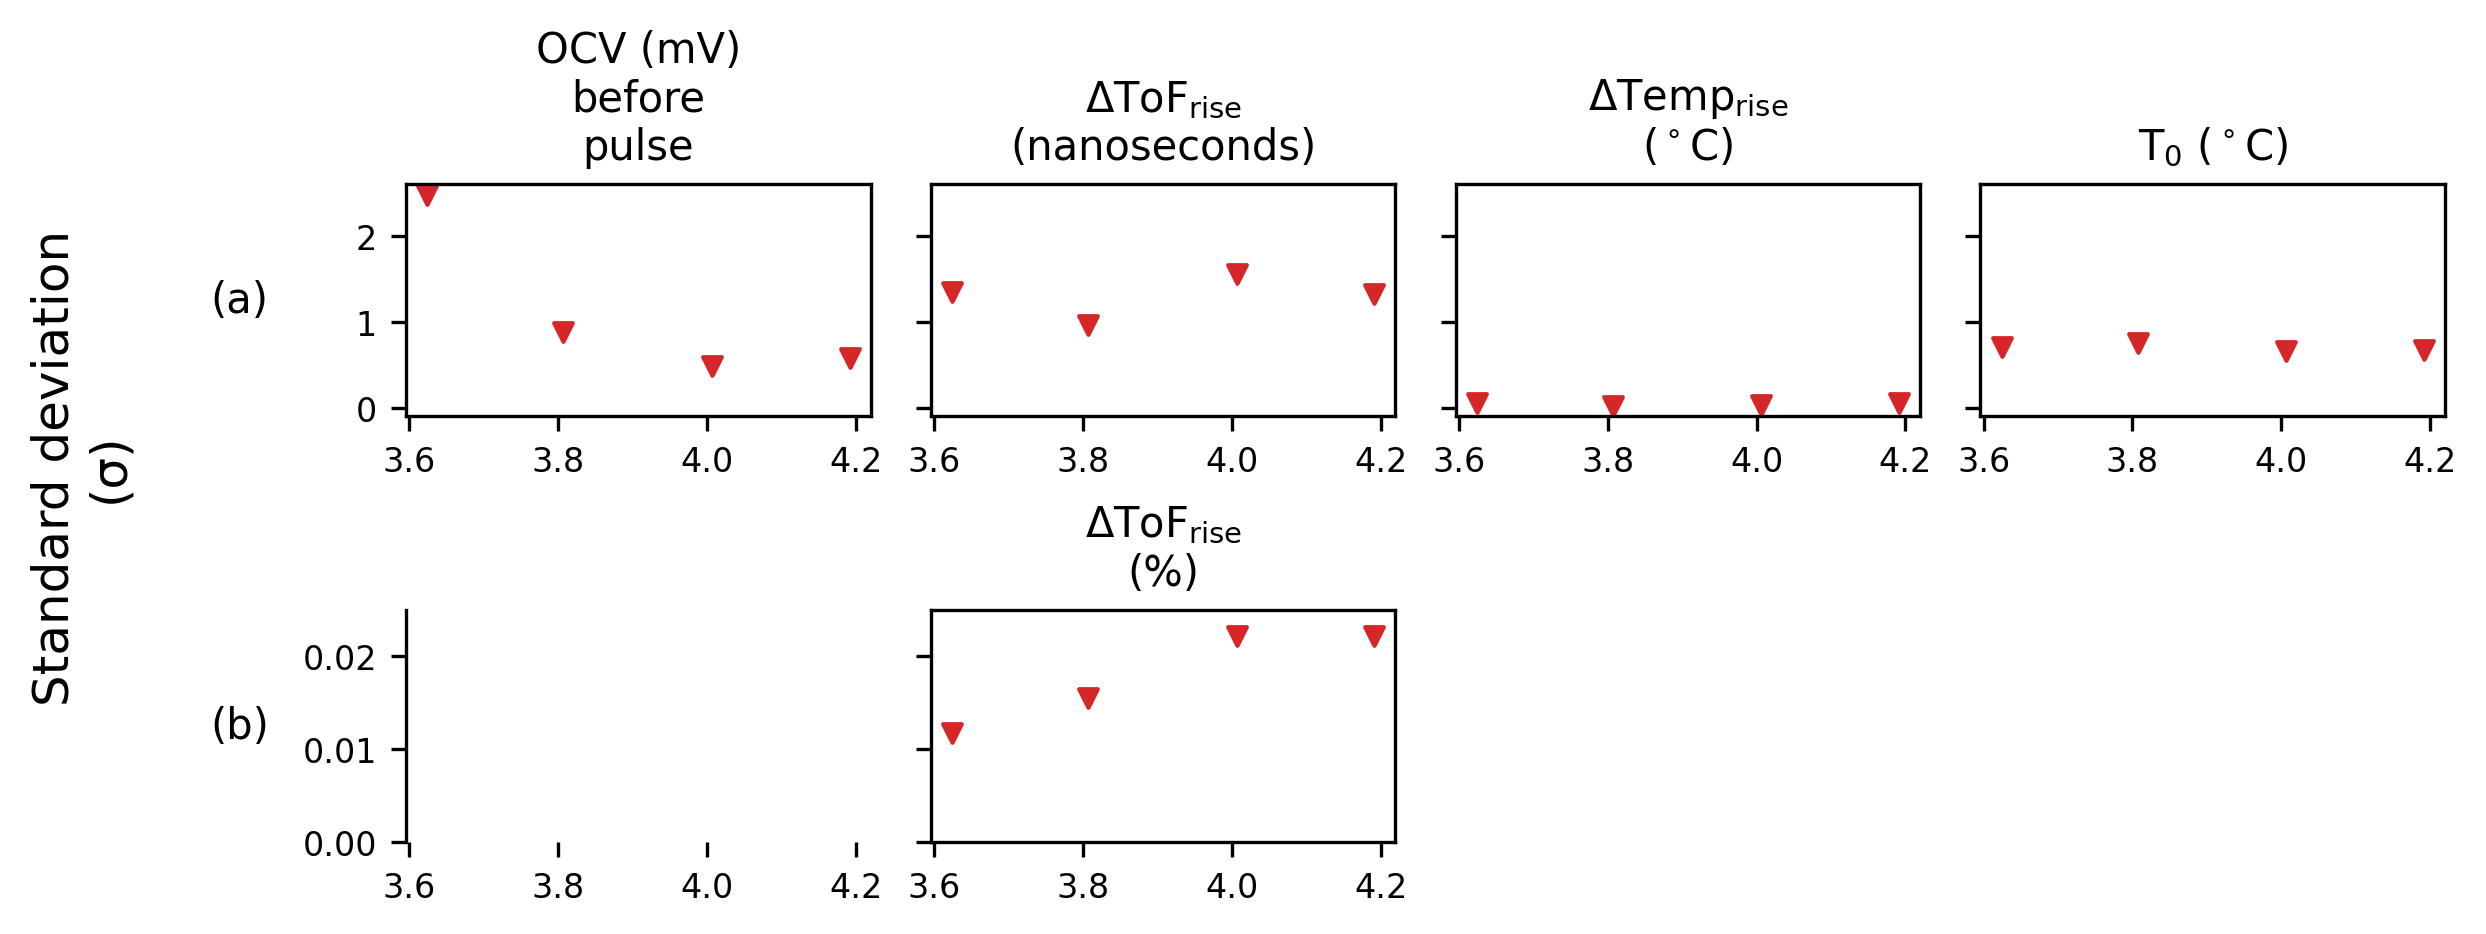

In [9]:
# Macro-trends: Standard Deviations
f, axs = plt.subplots(2, len(quantities), sharex='row', sharey='row',
        figsize=(8,3), constrained_layout=True, dpi=300)
f.patch.set_facecolor('white')

for j, quantity in enumerate(quantities):
    
    if (quantity != 'pre_pulse_ocv') & (quantity != 'post_pulse_ocv'):
        axs[0,j].scatter(
            ocvs_pre_mean, Standard_devs[quantity],
            color=marker_c, s=marker_s, marker=marker)
        axs[0, j].set_title(
            quantity_labels[quantity], fontsize=10)  
    else:
        axs[0,j].scatter(
            ocvs_pre_mean, np.array(Standard_devs[quantity])*1000,
            color=marker_c, s=marker_s, marker=marker) # Convert to mV for voltage data
        axs[0, j].set_title(
        'OCV (mV)\nbefore\npulse', fontsize=10)

# Add standard deviation stats for percentage quantities
# for j, quantity in enumerate(['tofs_delta_state_pct', 'tofs_rise_pct', 'tofs_overshoot_pct']):
for j, quantity in enumerate(['tofs_rise_pct']):
    axs[1, j+1].scatter(ocvs_pre_mean, Standard_devs_pct[quantity],
            color=marker_c, s=marker_s, marker=marker)
    axs[1, j+1].set_title(
        quantity_labels[quantity], fontsize=10)

# Turn off unused axes
for j in [2,3]:
    axs[1,j].axis('off')
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['bottom'].set_visible(False)

axs[0,0].set_xticks([3.6, 3.8, 4.0, 4.2])
axs[1,0].set_xticks([3.6, 3.8, 4.0, 4.2])
axs[1,0].set_ylim([0, 0.025])
axs[1,0].set_yticks([0, 0.01, 0.02])
axs[0,0].set_ylabel('(a)',
    labelpad=15, ha='center', va='center', rotation=0)
axs[1,0].set_ylabel('(b)',
    labelpad=15, ha='center', va='center', rotation=0)
f.align_ylabels()
f.supylabel('Standard deviation\n(σ)', ha='center')

save_filename = 'Exp1_stds'
utils.save_figure(f, visualistion_path, save_filename, 'png')


In [10]:
# Save some data
import json
with open(os.path.join(ancillary_data_path,'stats_exp1.json'), 'w') as fp:
    json.dump(stats, fp)
with open(os.path.join(ancillary_data_path,'stats_pct_exp1.json'), 'w') as fp:
    json.dump(stats_pct, fp)